In [1]:
!nvidia-smi

Fri Mar 14 01:34:47 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   29C    P0             45W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [2]:
#!pip install tensorflow
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Import libraries

In [3]:
import tensorflow as tf # Access to models, datasets and training
from tensorflow.keras.datasets import cifar100 # Access to CIFAR-100
from tensorflow.keras.applications import ResNet50 # Access to pre-trained model
from tensorflow.keras import layers, models, optimizers # Access to building blocks of a model
from tensorflow import keras # Access to stuff for model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard, CSVLogger
from sklearn.model_selection import train_test_split # To help split dataset up
from sklearn.metrics import confusion_matrix, classification_report # Analysis of model train, val & test
import numpy as np # Manipulate data
import pandas as pd # Statistical analysis of data
import seaborn as sns
import matplotlib.pyplot as plt # Plot data

# Load data

In [4]:
# Load CIFAR-100 dataset
(X_train, y_train), (X_test, y_test) = cifar100.load_data(label_mode='fine')

# Split (8000) of training data into temporary set
X_temp, X_train, y_temp, y_train = train_test_split(X_train, y_train, test_size=0.84, stratify=y_train, random_state=42)
print(f"X_temp.shape: {X_temp.shape}\n")

# Split temp data into equal validation (4000) and testing (4000) data
X_temp_val, X_temp_test, y_temp_val, y_temp_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)
print(f"X_temp_val.shape: {X_temp_val.shape}")
print(f"y_temp_val.shape: {y_temp_val.shape}")
print(f"X_temp_test.shape: {X_temp_test.shape}")
print(f"y_temp_test.shape: {y_temp_test.shape}\n")

# Split test data into validation (5000) and testing (5000)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test, random_state=42)

# Add temp_val to validation (9000) and temp_test to testing (9000) to get a 70/15/15 data split
X_val = np.concatenate((X_val, X_temp_val), axis=0)
y_val = np.concatenate((y_val, y_temp_val), axis=0)
X_test = np.concatenate((X_test, X_temp_test), axis=0)
y_test = np.concatenate((y_test, y_temp_test), axis=0)

print(f"X_train.shape: {X_train.shape}")
print(f"y_train.shape: {y_train.shape}")
print(f"X_val.shape: {X_val.shape}")
print(f"y_val.shape: {y_val.shape}")
print(f"X_test.shape: {X_test.shape}")
print(f"y_test.shape: {y_test.shape}")

169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
X_temp.shape: (8000, 32, 32, 3)

X_temp_val.shape: (4000, 32, 32, 3)
y_temp_val.shape: (4000, 1)
X_temp_test.shape: (4000, 32, 32, 3)
y_temp_test.shape: (4000, 1)

X_train.shape: (42000, 32, 32, 3)
y_train.shape: (42000, 1)
X_val.shape: (9000, 32, 32, 3)
y_val.shape: (9000, 1)
X_test.shape: (9000, 32, 32, 3)
y_test.shape: (9000, 1)


labels[17107].shape: (1,)
imgs[17107].shape: (32, 32, 3)


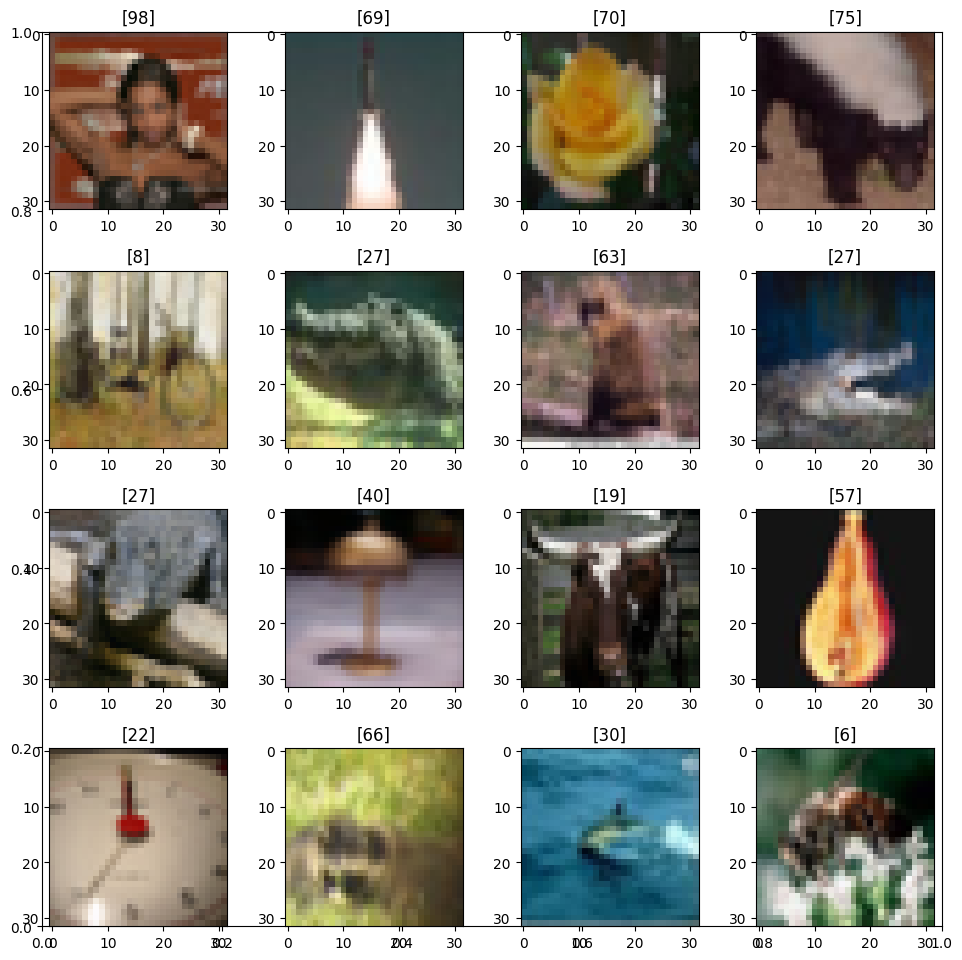

In [5]:
idxs_disp = []
def display_imgs(imgs, labels,norm_version):
    plt.subplots(figsize=(10,10))
    if norm_version == 0:
        for i in range(16):
            plt.subplot(4, 4, i+1)
            k = np.random.randint(0, imgs.shape[0])
            idxs_disp.append(k)
            if i == 0:
                print(f"labels[{k}].shape: {labels[k].shape}")
                print(f"imgs[{k}].shape: {imgs[k].shape}")
            plt.title(labels[k])
            plt.imshow(imgs[k])
    else:
        for i in range(16):
            plt.subplot(4, 4, i+1)
            k = idxs_disp[i]
            if i == 0:
                print(f"labels[{k}].shape: {labels[k].shape}")
                print(f"imgs[{k}].shape: {imgs[k].shape}")
            plt.title(labels[k])
            plt.imshow(imgs[k])
    plt.tight_layout()
    plt.show()

display_imgs(X_train, y_train, 0)

labels[17107].shape: (1,)
imgs[17107].shape: (32, 32, 3)


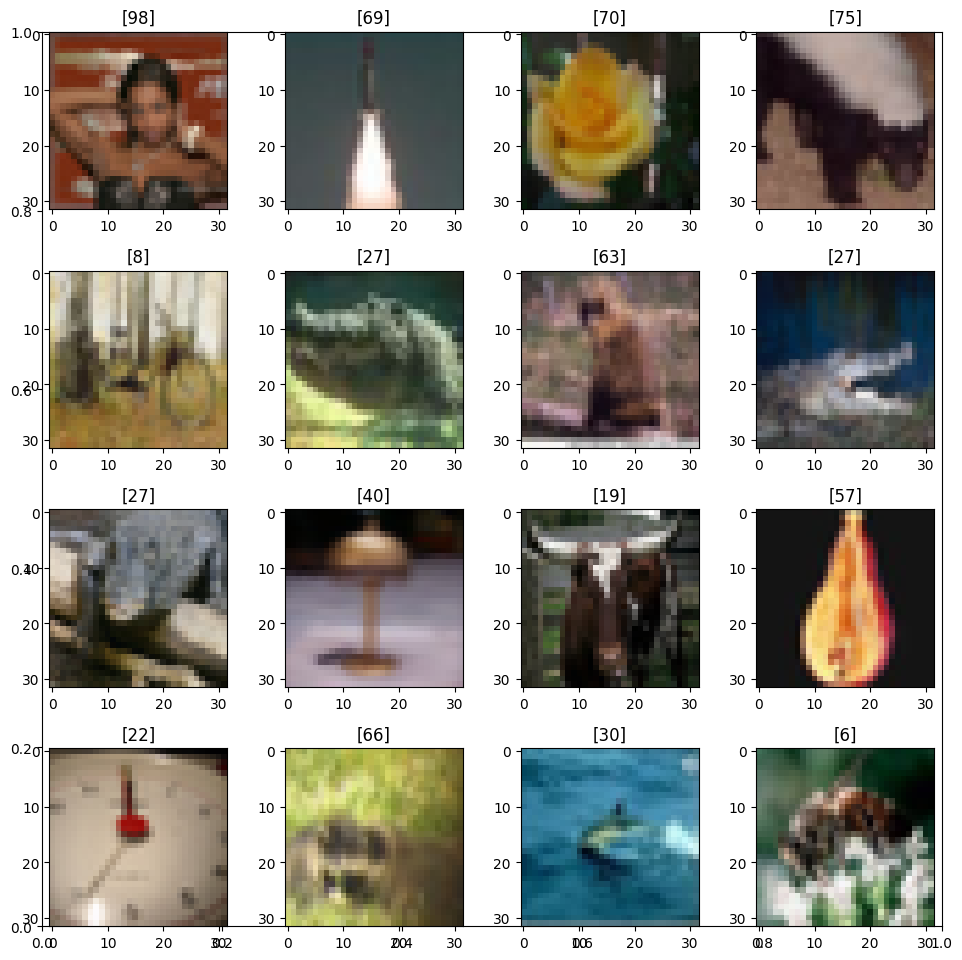

In [6]:
# Normalise images (scale to range [0, 1]) - Improves convergence speed & accuracy
X_train, X_val, X_test = X_train / 255.0, X_val / 255.0, X_test / 255.0
display_imgs(X_train, y_train,1)

In [7]:
#train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(50000).batch(64)
#val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(64)
#test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(64)

labels_names = ['beaver','dolphin','otter','seal','whale','aquarium fish','flatfish','ray','shark','trout',
               'orchids','poppies','roses','sunflowers','tulips','bottles','bowls','cans','cups','plates',
               'apples','mushrooms','oranges','pears','sweet peppers','clock','computer keyboard','lamp',
               'telephone','television','bed','chair','couch','table','wardrobe','bee','beetle','butterfly',
               'caterpillar','cockroach','bear','leopard','lion','tiger','wolf','bridge','castle','house',
               'road','skyscraper','cloud','forest','mountain','plain','sea','camel','cattle','chimpanzee',
               'elephant','kangaroo','fox','porcupine','possum','raccoon','skunk','crab','lobster','snail',
               'spider','worm','baby','boy','girl','man','woman','crocodile','dinosaur','lizard','snake',
               'turtle','hamster','mouse','rabbit','shrew','squirrel','maple','oak','palm','pine','willow',
               'bicycle','bus','motorcycle','pickup truck','train','lawn-mower','rocket','streetcar','tank',
               'tractor']

# Create TensorFlow datasets (may need imgs as 224,224 later on)

batch_size = 64
train_dataset = (tf.data.Dataset.from_tensor_slices((X_train, y_train))
                 .map(lambda x, y: (tf.image.resize(x, (32, 32)),
                                    tf.squeeze(tf.one_hot(y, depth=100, dtype=tf.float32))))  # Remove extra dimension
                 .batch(batch_size))

val_dataset = (tf.data.Dataset.from_tensor_slices((X_val, y_val))
               .map(lambda x, y: (tf.image.resize(x, (32, 32)),
                                  tf.squeeze(tf.one_hot(y, depth=100, dtype=tf.float32))))  # Remove extra dimension
               .batch(batch_size))

test_dataset = (tf.data.Dataset.from_tensor_slices((X_test, y_test))
                 .map(lambda x, y: (tf.image.resize(x, (32, 32)),
                                    tf.squeeze(tf.one_hot(y, depth=100, dtype=tf.float32))))  # Remove extra dimension
                 .batch(batch_size))

print(f"Training dataset:\n {train_dataset}")
for img, lbl in train_dataset.take(1):
    #if isinstance(batch, tuple) and len(batch) == 2:
    print(f"Image shape: {img.shape}")  # Should be (batch_size, 32, 32, 3)
    print(f"Label shape: {lbl.shape}")  # Should be (batch_size, 10)
    del img,lbl
print(f"\nValidation dataset:\n {val_dataset}")
for img, lbl in val_dataset.take(1):
    #if isinstance(batch, tuple) and len(batch) == 2:
    print(f"Image shape: {img.shape}")  # Should be (batch_size, 32, 32, 3)
    print(f"Label shape: {lbl.shape}")  # Should be (batch_size, 10)
    del img,lbl
print(f"\nTesting dataset:\n {test_dataset}")
for img, lbl in test_dataset.take(1):
    #if isinstance(batch, tuple) and len(batch) == 2:
    print(f"Image shape: {img.shape}")  # Should be (batch_size, 32, 32, 3)
    print(f"Label shape: {lbl.shape}")  # Should be (batch_size, 10)
    del img,lbl

Training dataset:
 <_BatchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100), dtype=tf.float32, name=None))>
Image shape: (64, 32, 32, 3)
Label shape: (64, 100)

Validation dataset:
 <_BatchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100), dtype=tf.float32, name=None))>
Image shape: (64, 32, 32, 3)
Label shape: (64, 100)

Testing dataset:
 <_BatchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100), dtype=tf.float32, name=None))>
Image shape: (64, 32, 32, 3)
Label shape: (64, 100)


<ipython-input-8-b584abab378c>:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels_names, rotation=90, fontsize=15)


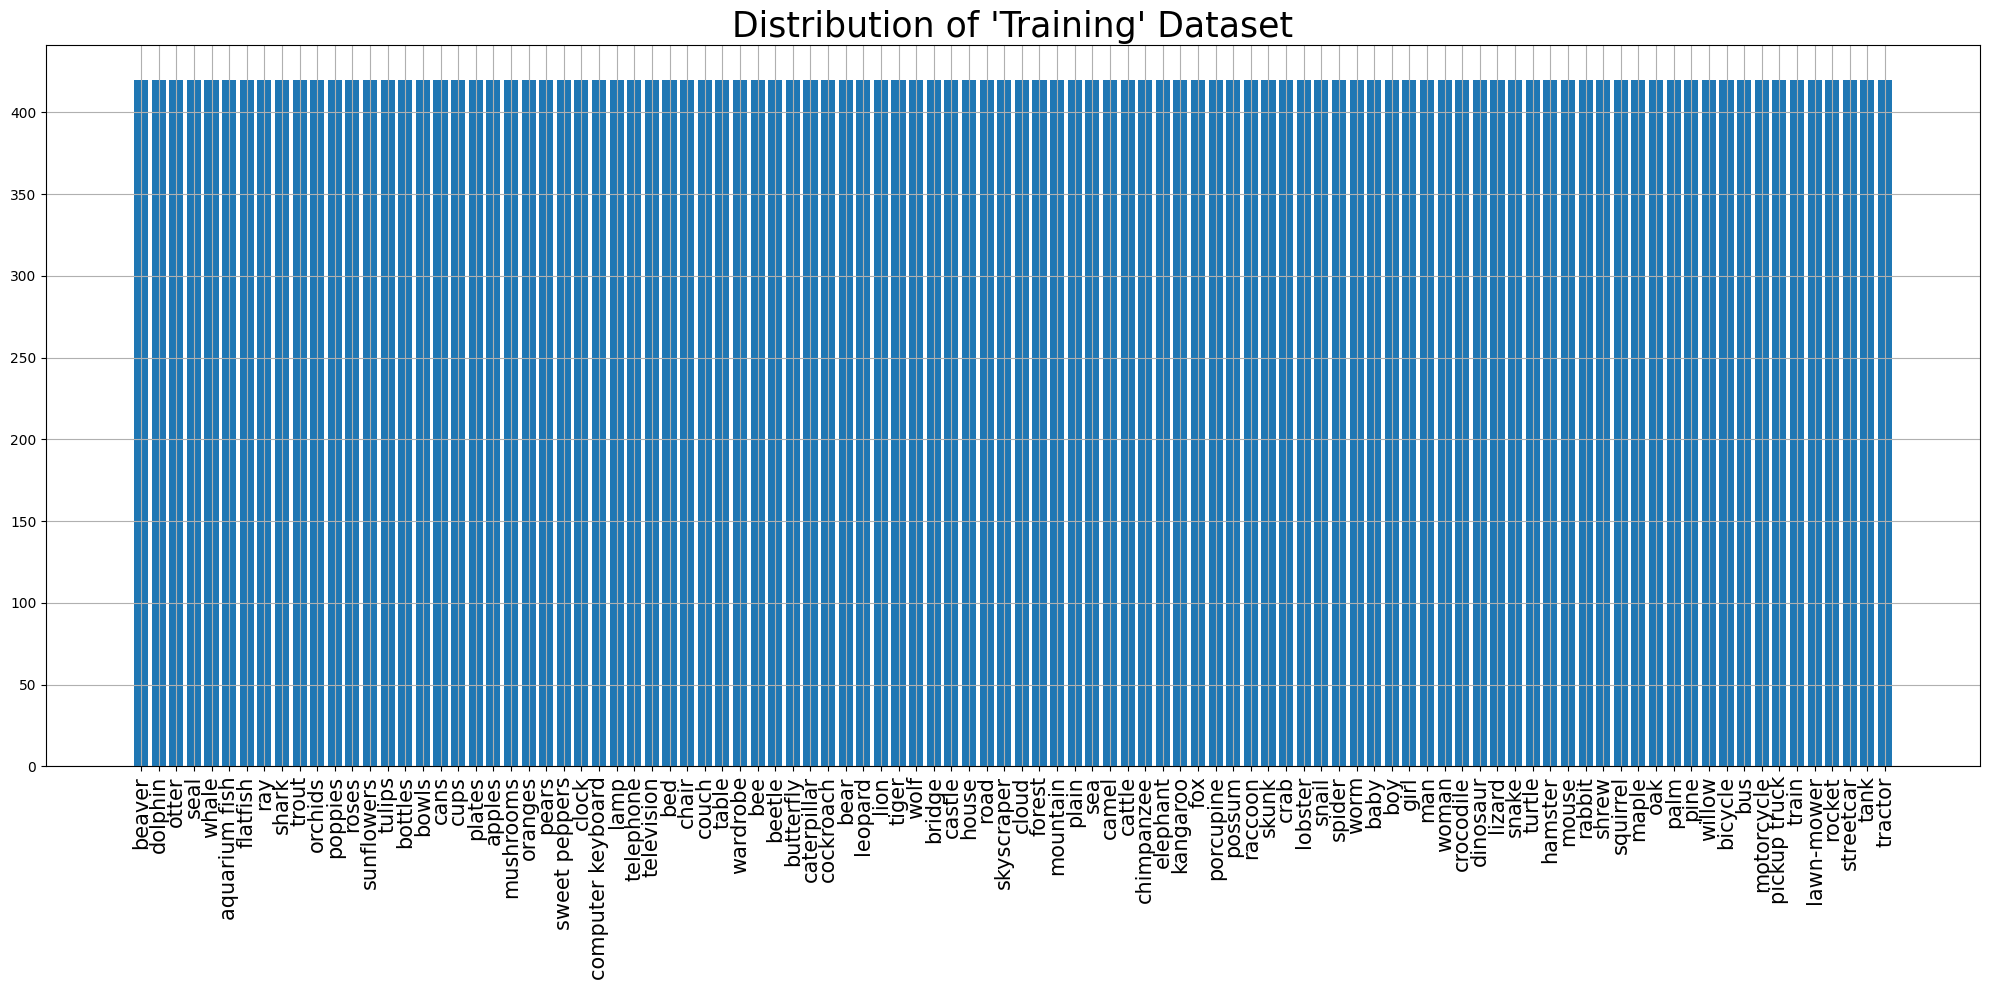

<ipython-input-8-b584abab378c>:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels_names, rotation=90, fontsize=15)


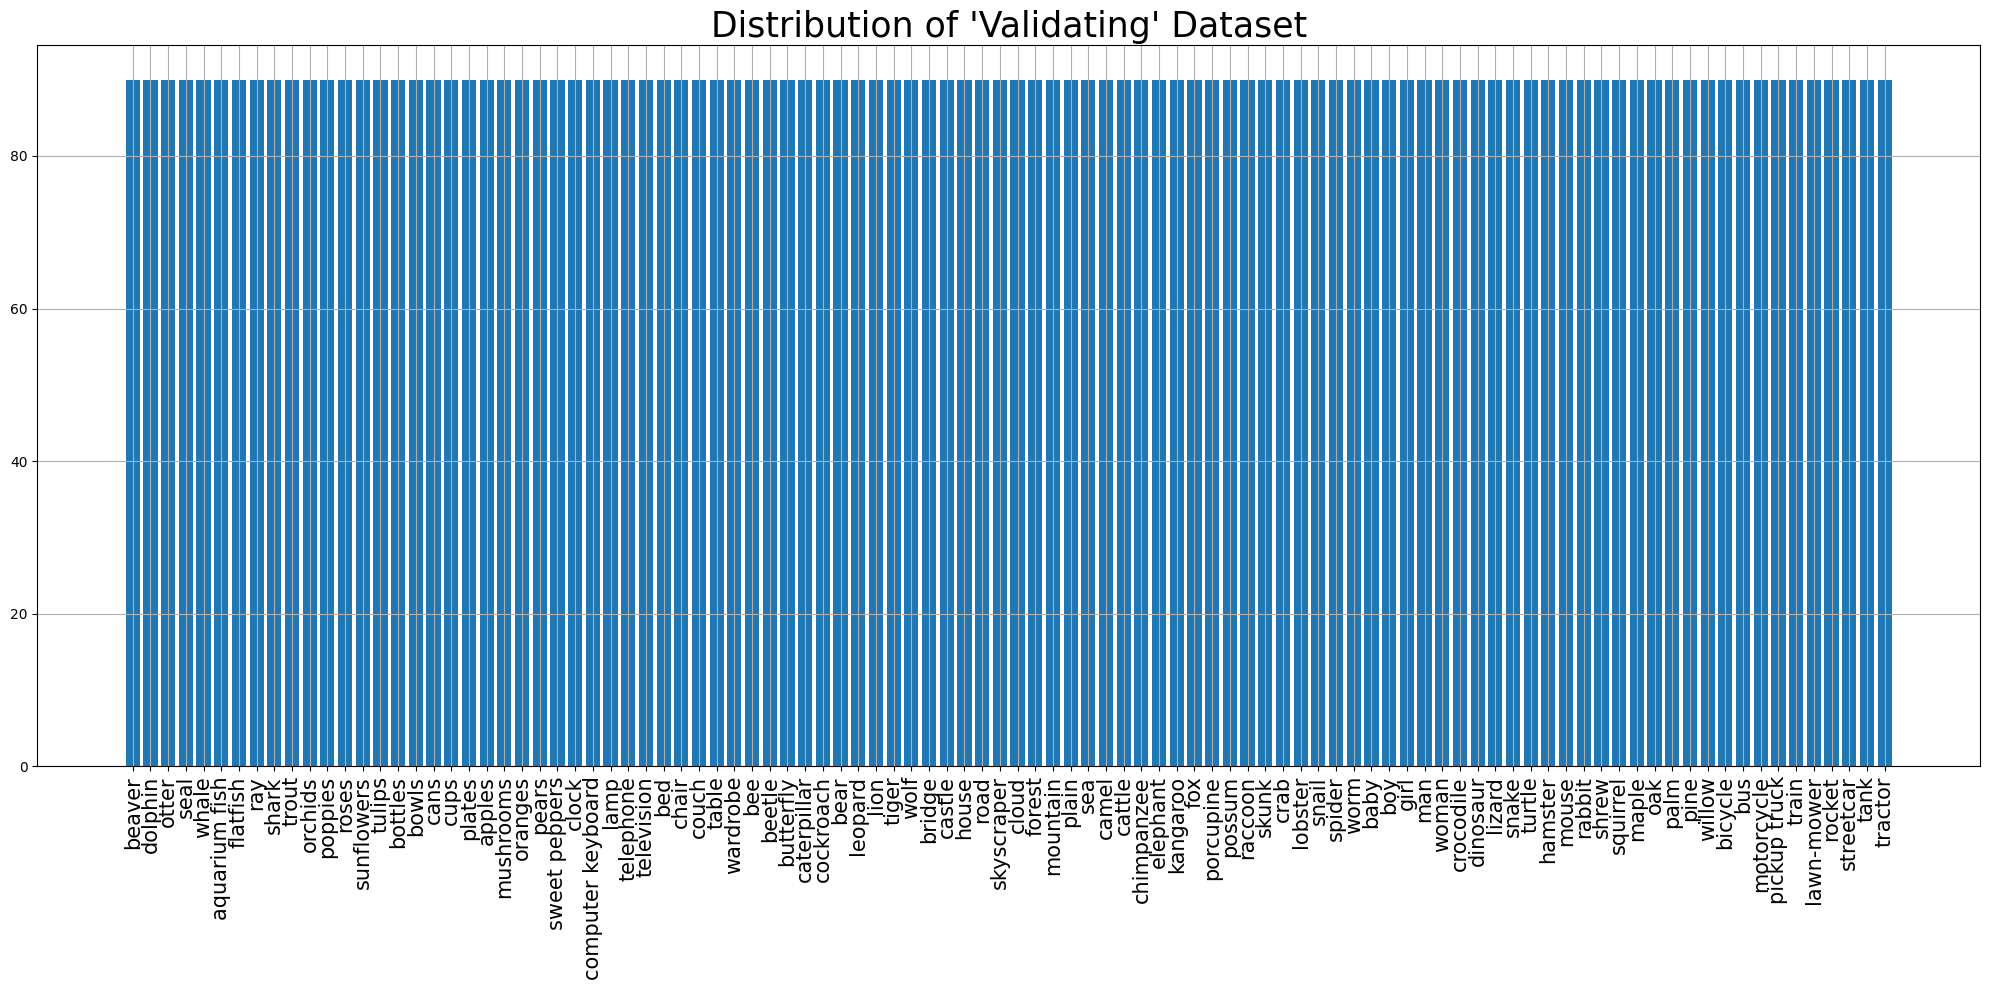

<ipython-input-8-b584abab378c>:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels_names, rotation=90, fontsize=15)


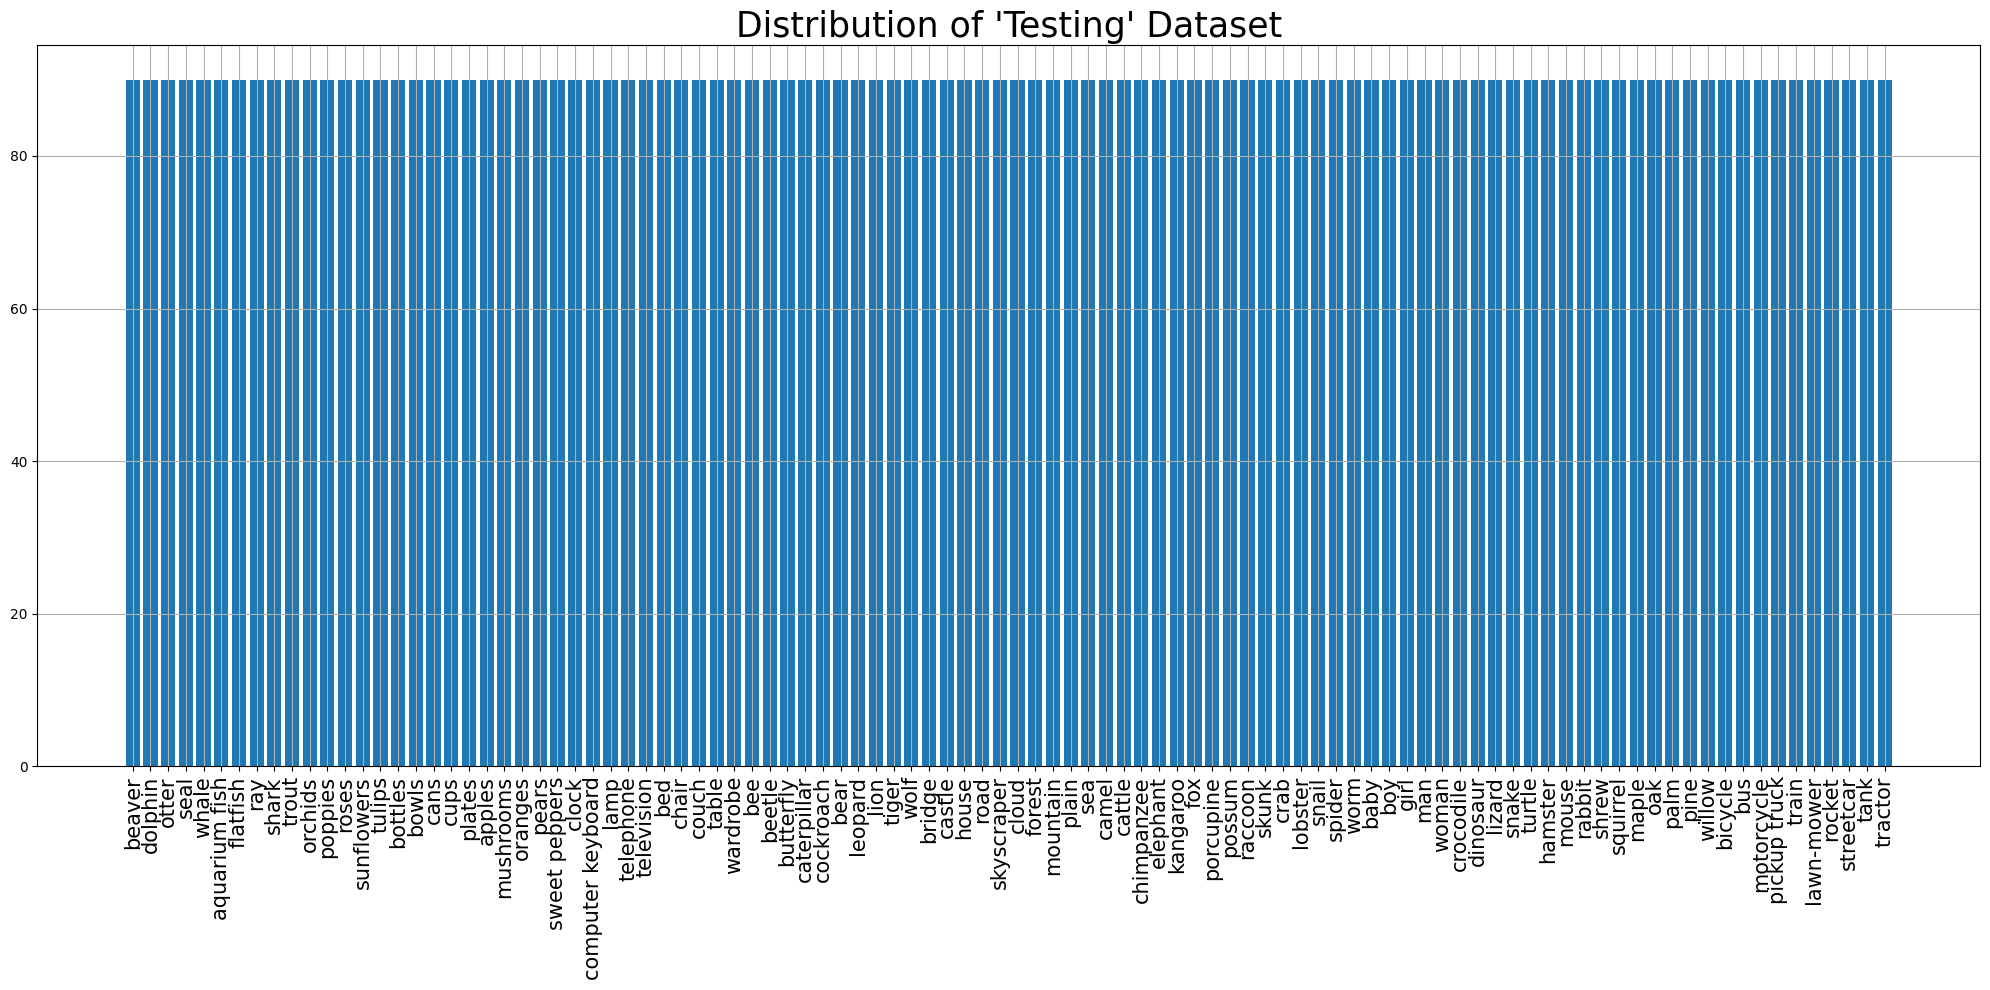

In [8]:
def class_distrib(y, labels_names, dataset_name):
    counts = pd.DataFrame(data=y).value_counts().sort_index()
    #print(f"counts:\n{counts}")
    fig, ax = plt.subplots(figsize=(20,10))
    ax.bar(labels_names, counts)
    ax.set_xticklabels(labels_names, rotation=90, fontsize=15)
    plt.title(f"Distribution of '{dataset_name}' Dataset", fontsize=25)
    plt.grid()
    plt.tight_layout()
    plt.show()
class_distrib(y_train, labels_names, "Training")
class_distrib(y_val, labels_names, "Validating")
class_distrib(y_test, labels_names, "Testing")

In [9]:
#print(train_dataset.len())

# Define Model

In [10]:
def build_lenet():
    # Let-Net5 Conv-net architecture
    model = models.Sequential([
        layers.Conv2D(6, kernel_size=(5, 5), activation='tanh', padding="same", input_shape=(32,32,3)),
        layers.AveragePooling2D(pool_size=(2, 2), strides=(2,2)),

        layers.Conv2D(16, kernel_size=(5, 5), activation='tanh'),
        layers.AveragePooling2D(pool_size=(2, 2), strides=(2,2)),

        layers.Flatten(),
        layers.Dense(120, activation='tanh'),
        layers.Dense(84, activation='tanh'),
        layers.Dense(100, activation='softmax')  # 100 classes
    ])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                  loss='categorical_crossentropy', # Or sparse?
                  metrics=['accuracy'])
    return model

# Build the model
model = build_lenet()
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 6)           │             456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d (AveragePooling2D) │ (None, 16, 16, 6)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 12, 12, 16)          │           2,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_1                  │ (None, 6, 6, 16)            │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 576)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 120)                 │          69,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 84)                  │          10,164 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 100)                 │           8,500 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 90,776 (354.59 KB)

 Trainable params: 90,776 (354.59 KB)

 Non-trainable params: 0 (0.00 B)

# Train Model & Track Training/Validation Error

In [11]:
# reduceLR = ReduceLROnPateau(monitor='val_accuracy', factor=0.1, patience=3, min_delta=0.01, mode="auto")

# Train model
history = model.fit(train_dataset, validation_data=val_dataset, epochs=20, verbose=1)

Epoch 1/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 22s 16ms/step - accuracy: 0.0617 - loss: 4.2293 - val_accuracy: 0.1410 - val_loss: 3.7386
Epoch 2/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1573 - loss: 3.6542 - val_accuracy: 0.1753 - val_loss: 3.5585
Epoch 3/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1859 - loss: 3.4683 - val_accuracy: 0.1962 - val_loss: 3.4519
Epoch 4/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2097 - loss: 3.3348 - val_accuracy: 0.2100 - val_loss: 3.3773
Epoch 5/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2281 - loss: 3.2263 - val_accuracy: 0.2163 - val_loss: 3.3191
Epoch 6/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2445 - loss: 3.1378 - val_accuracy: 0.2200 - val_loss: 3.2781
Epoch 7/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2589 - loss: 3.0632 - val_accuracy: 0.2262 - val_loss: 3.2543
Epoch 8/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2676 - loss: 2.9991 - val_accuracy: 

# Plot Training & Validation Error

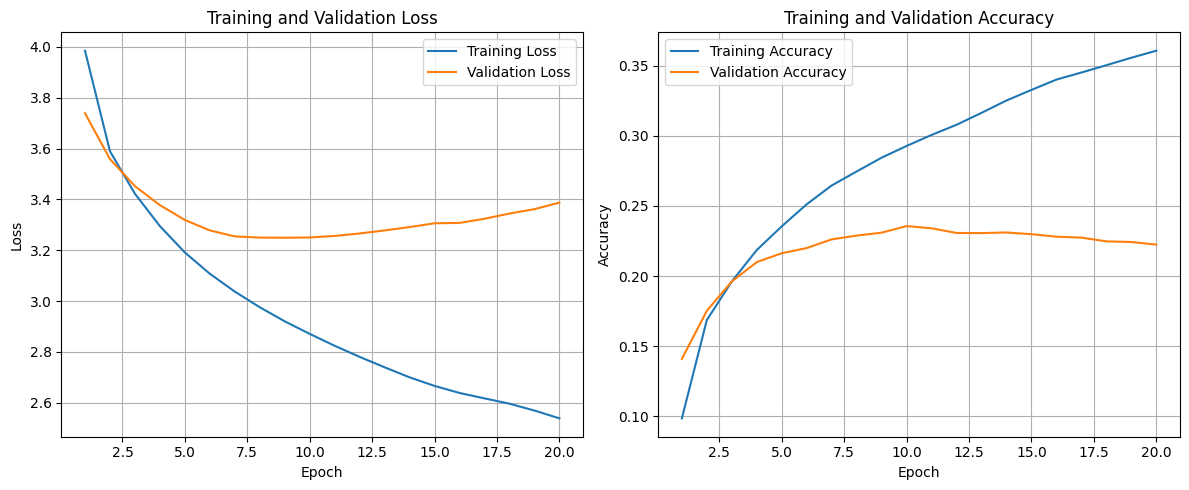

In [12]:
# Extract loss and accuracy
epochs = range(1,len(history.history['loss'])+1)
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']


def plot_evidence(epochs, train_loss, val_loss, train_acc, val_acc):
    # Plot Training and Validation Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid()

    # Plot Training and Validation Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

plot_evidence(epochs, train_loss, val_loss, train_acc, val_acc)

# Evaluate Model on Test Data

In [13]:
# Evaluate on test data
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc*100:.2f}%")

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2256 - loss: 3.3893
Test Accuracy: 22.07%


# Generate Confusion Matrix

282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step


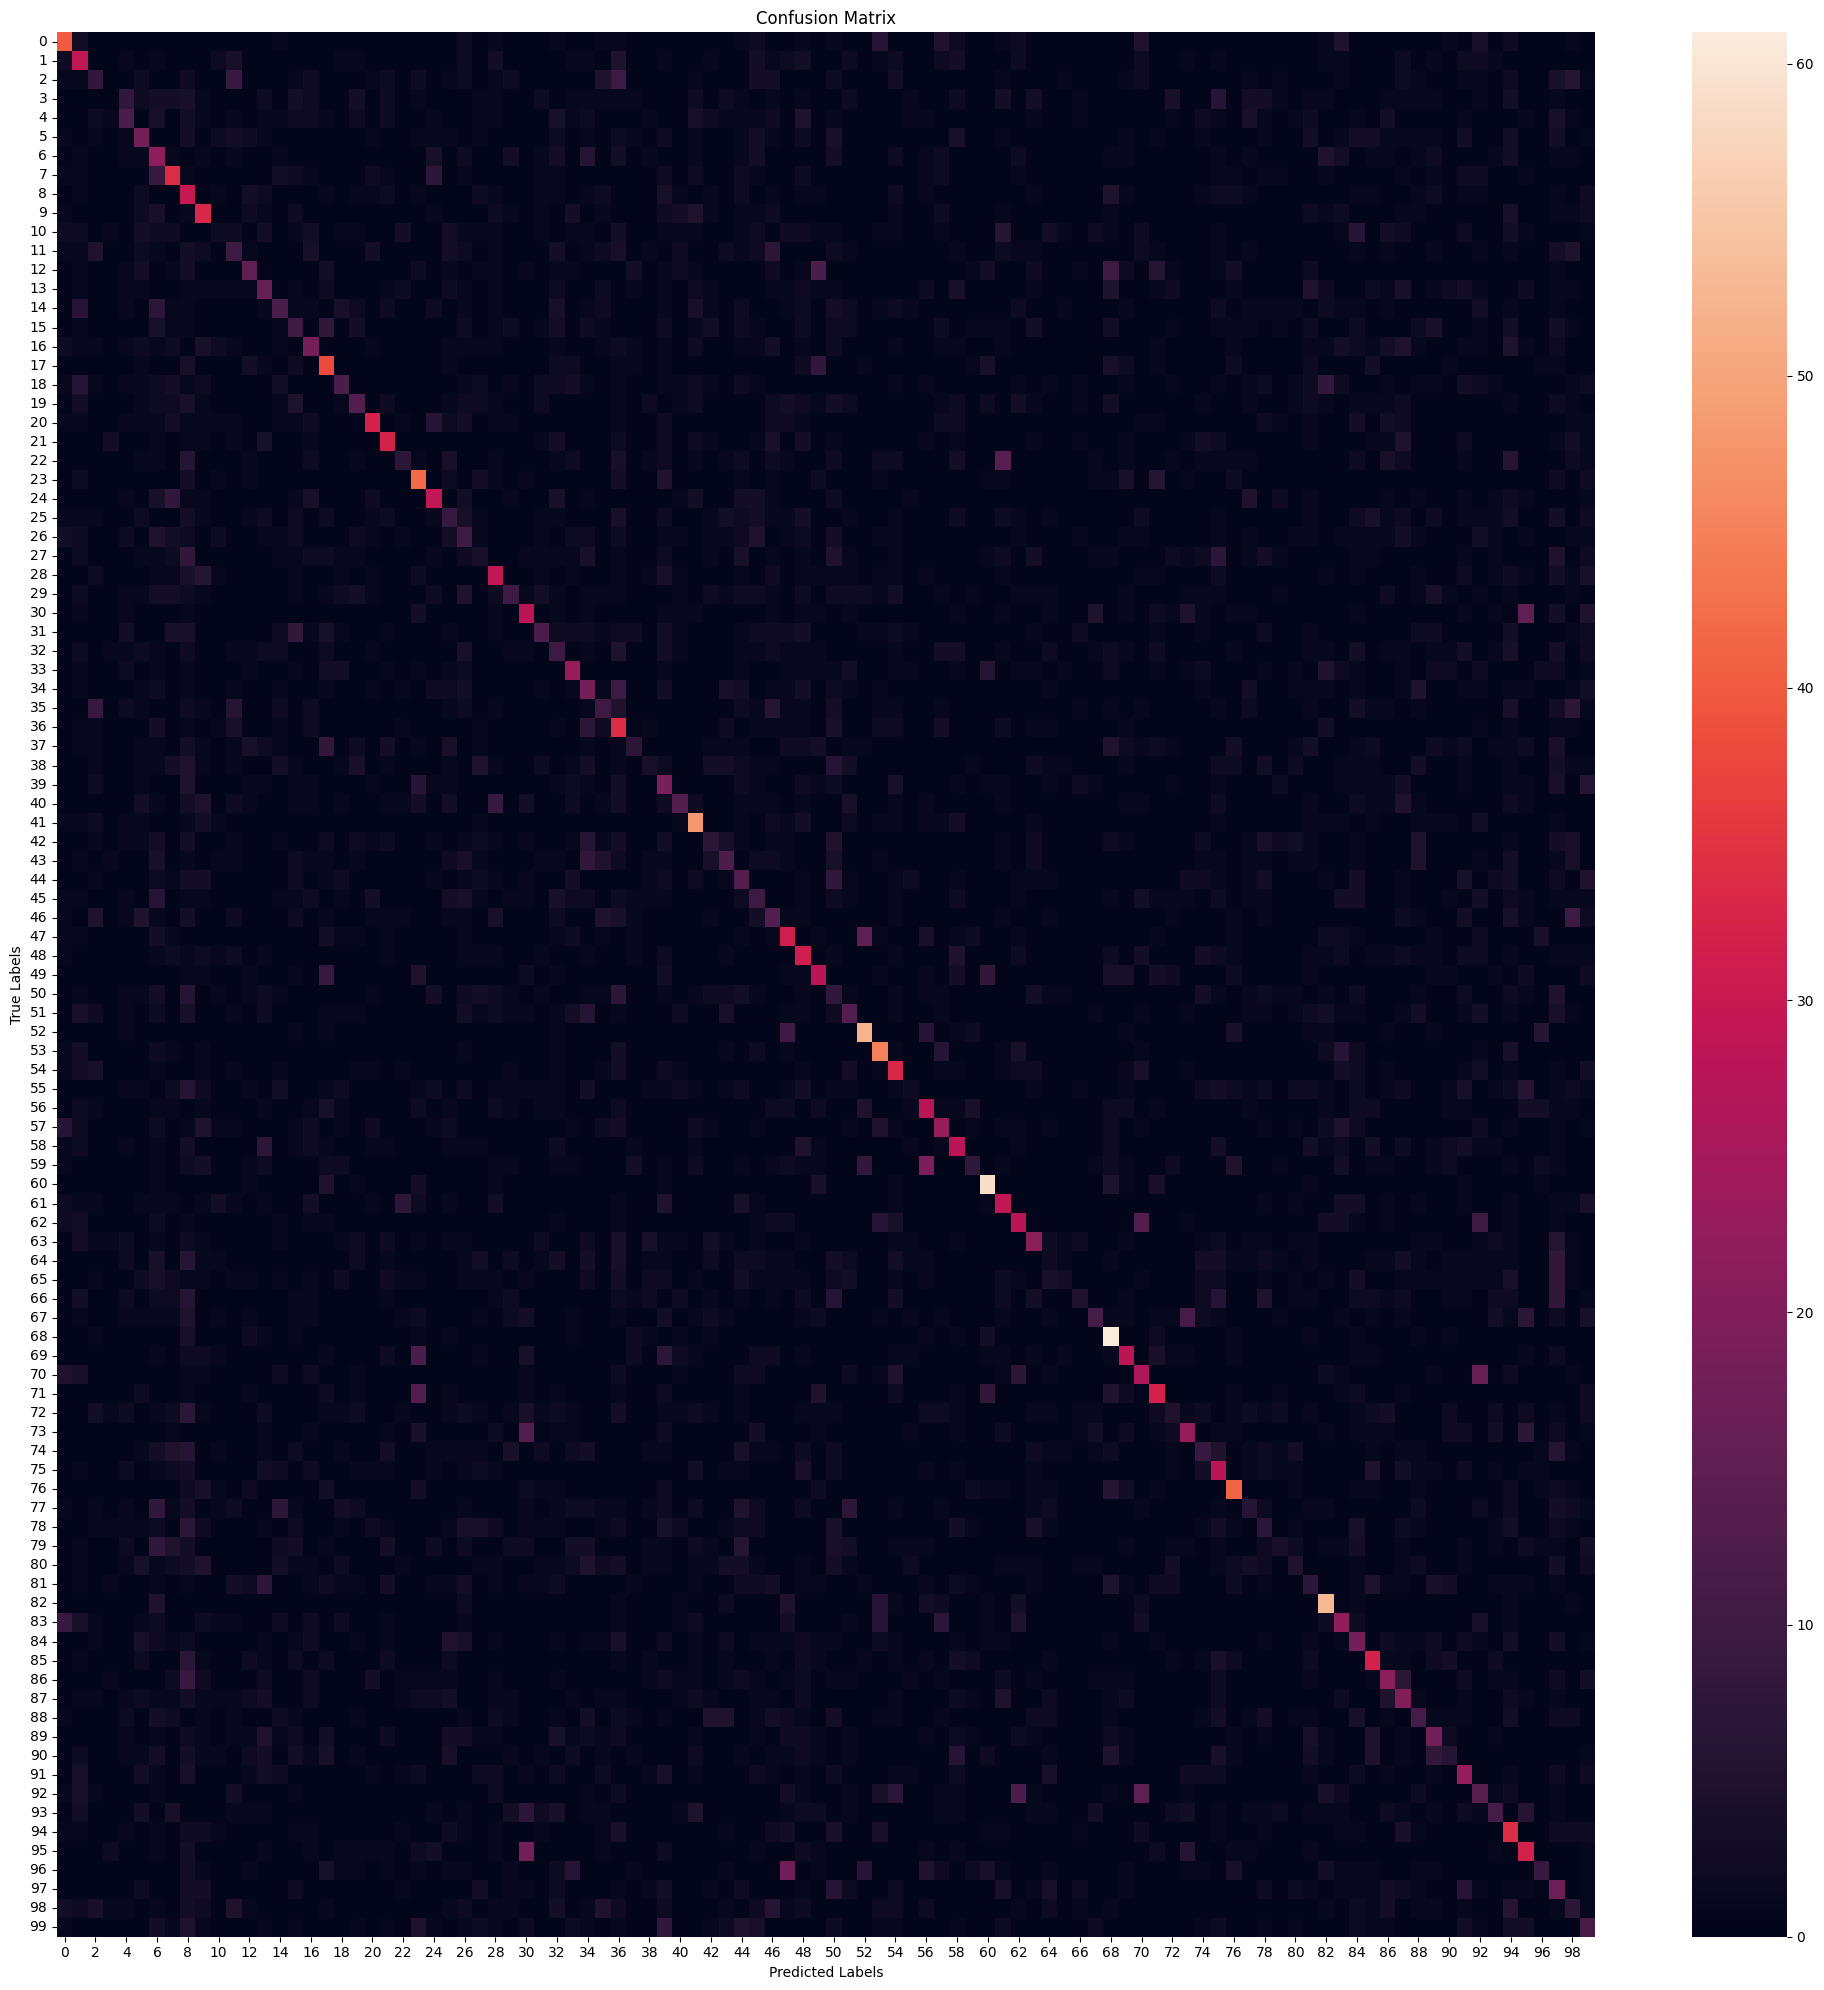

In [14]:
# Get predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = y_test.flatten()

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(20, 20))
sns.heatmap(conf_matrix) #cmap='Blues', fmt='d'
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

In [15]:
print(classification_report(y_true_classes, y_pred_classes, target_names=labels_names))

                   precision    recall  f1-score   support

           beaver       0.41      0.44      0.43        90
          dolphin       0.21      0.32      0.26        90
            otter       0.12      0.09      0.10        90
             seal       0.00      0.00      0.00        90
            whale       0.16      0.13      0.15        90
    aquarium fish       0.19      0.20      0.19        90
         flatfish       0.12      0.24      0.16        90
              ray       0.28      0.38      0.32        90
            shark       0.11      0.33      0.17        90
            trout       0.26      0.37      0.31        90
          orchids       0.06      0.02      0.03        90
          poppies       0.13      0.11      0.12        90
            roses       0.24      0.17      0.20        90
       sunflowers       0.17      0.18      0.17        90
           tulips       0.17      0.13      0.15        90
          bottles       0.11      0.11      0.11       

Epoch 1/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3563 - loss: 2.5433 - val_accuracy: 0.2184 - val_loss: 3.4207
Epoch 2/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3612 - loss: 2.5134 - val_accuracy: 0.2177 - val_loss: 3.4451
Epoch 3/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3670 - loss: 2.4863 - val_accuracy: 0.2191 - val_loss: 3.4579
Epoch 4/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3719 - loss: 2.4620 - val_accuracy: 0.2196 - val_loss: 3.4645
Epoch 5/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3792 - loss: 2.4418 - val_accuracy: 0.2196 - val_loss: 3.4764
Epoch 6/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3834 - loss: 2.4201 - val_accuracy: 0.2194 - val_loss: 3.4984
Epoch 7/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3883 - loss: 2.3988 - val_accuracy: 0.2154 - val_loss: 3.5259
Epoch 8/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3930 - loss: 2.3772 - val_accuracy: 0.

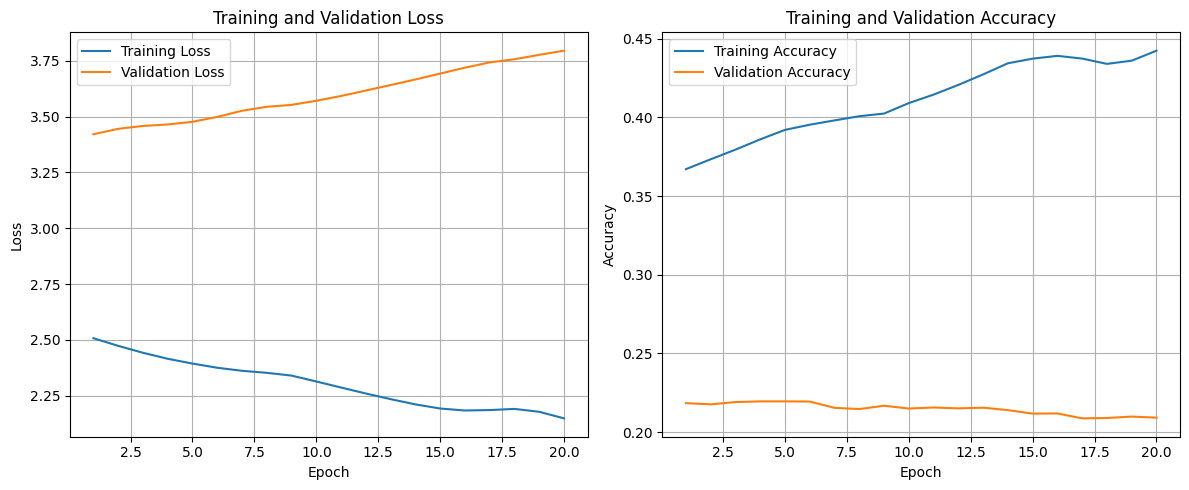

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2175 - loss: 3.7815
Test Accuracy: 20.91%
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


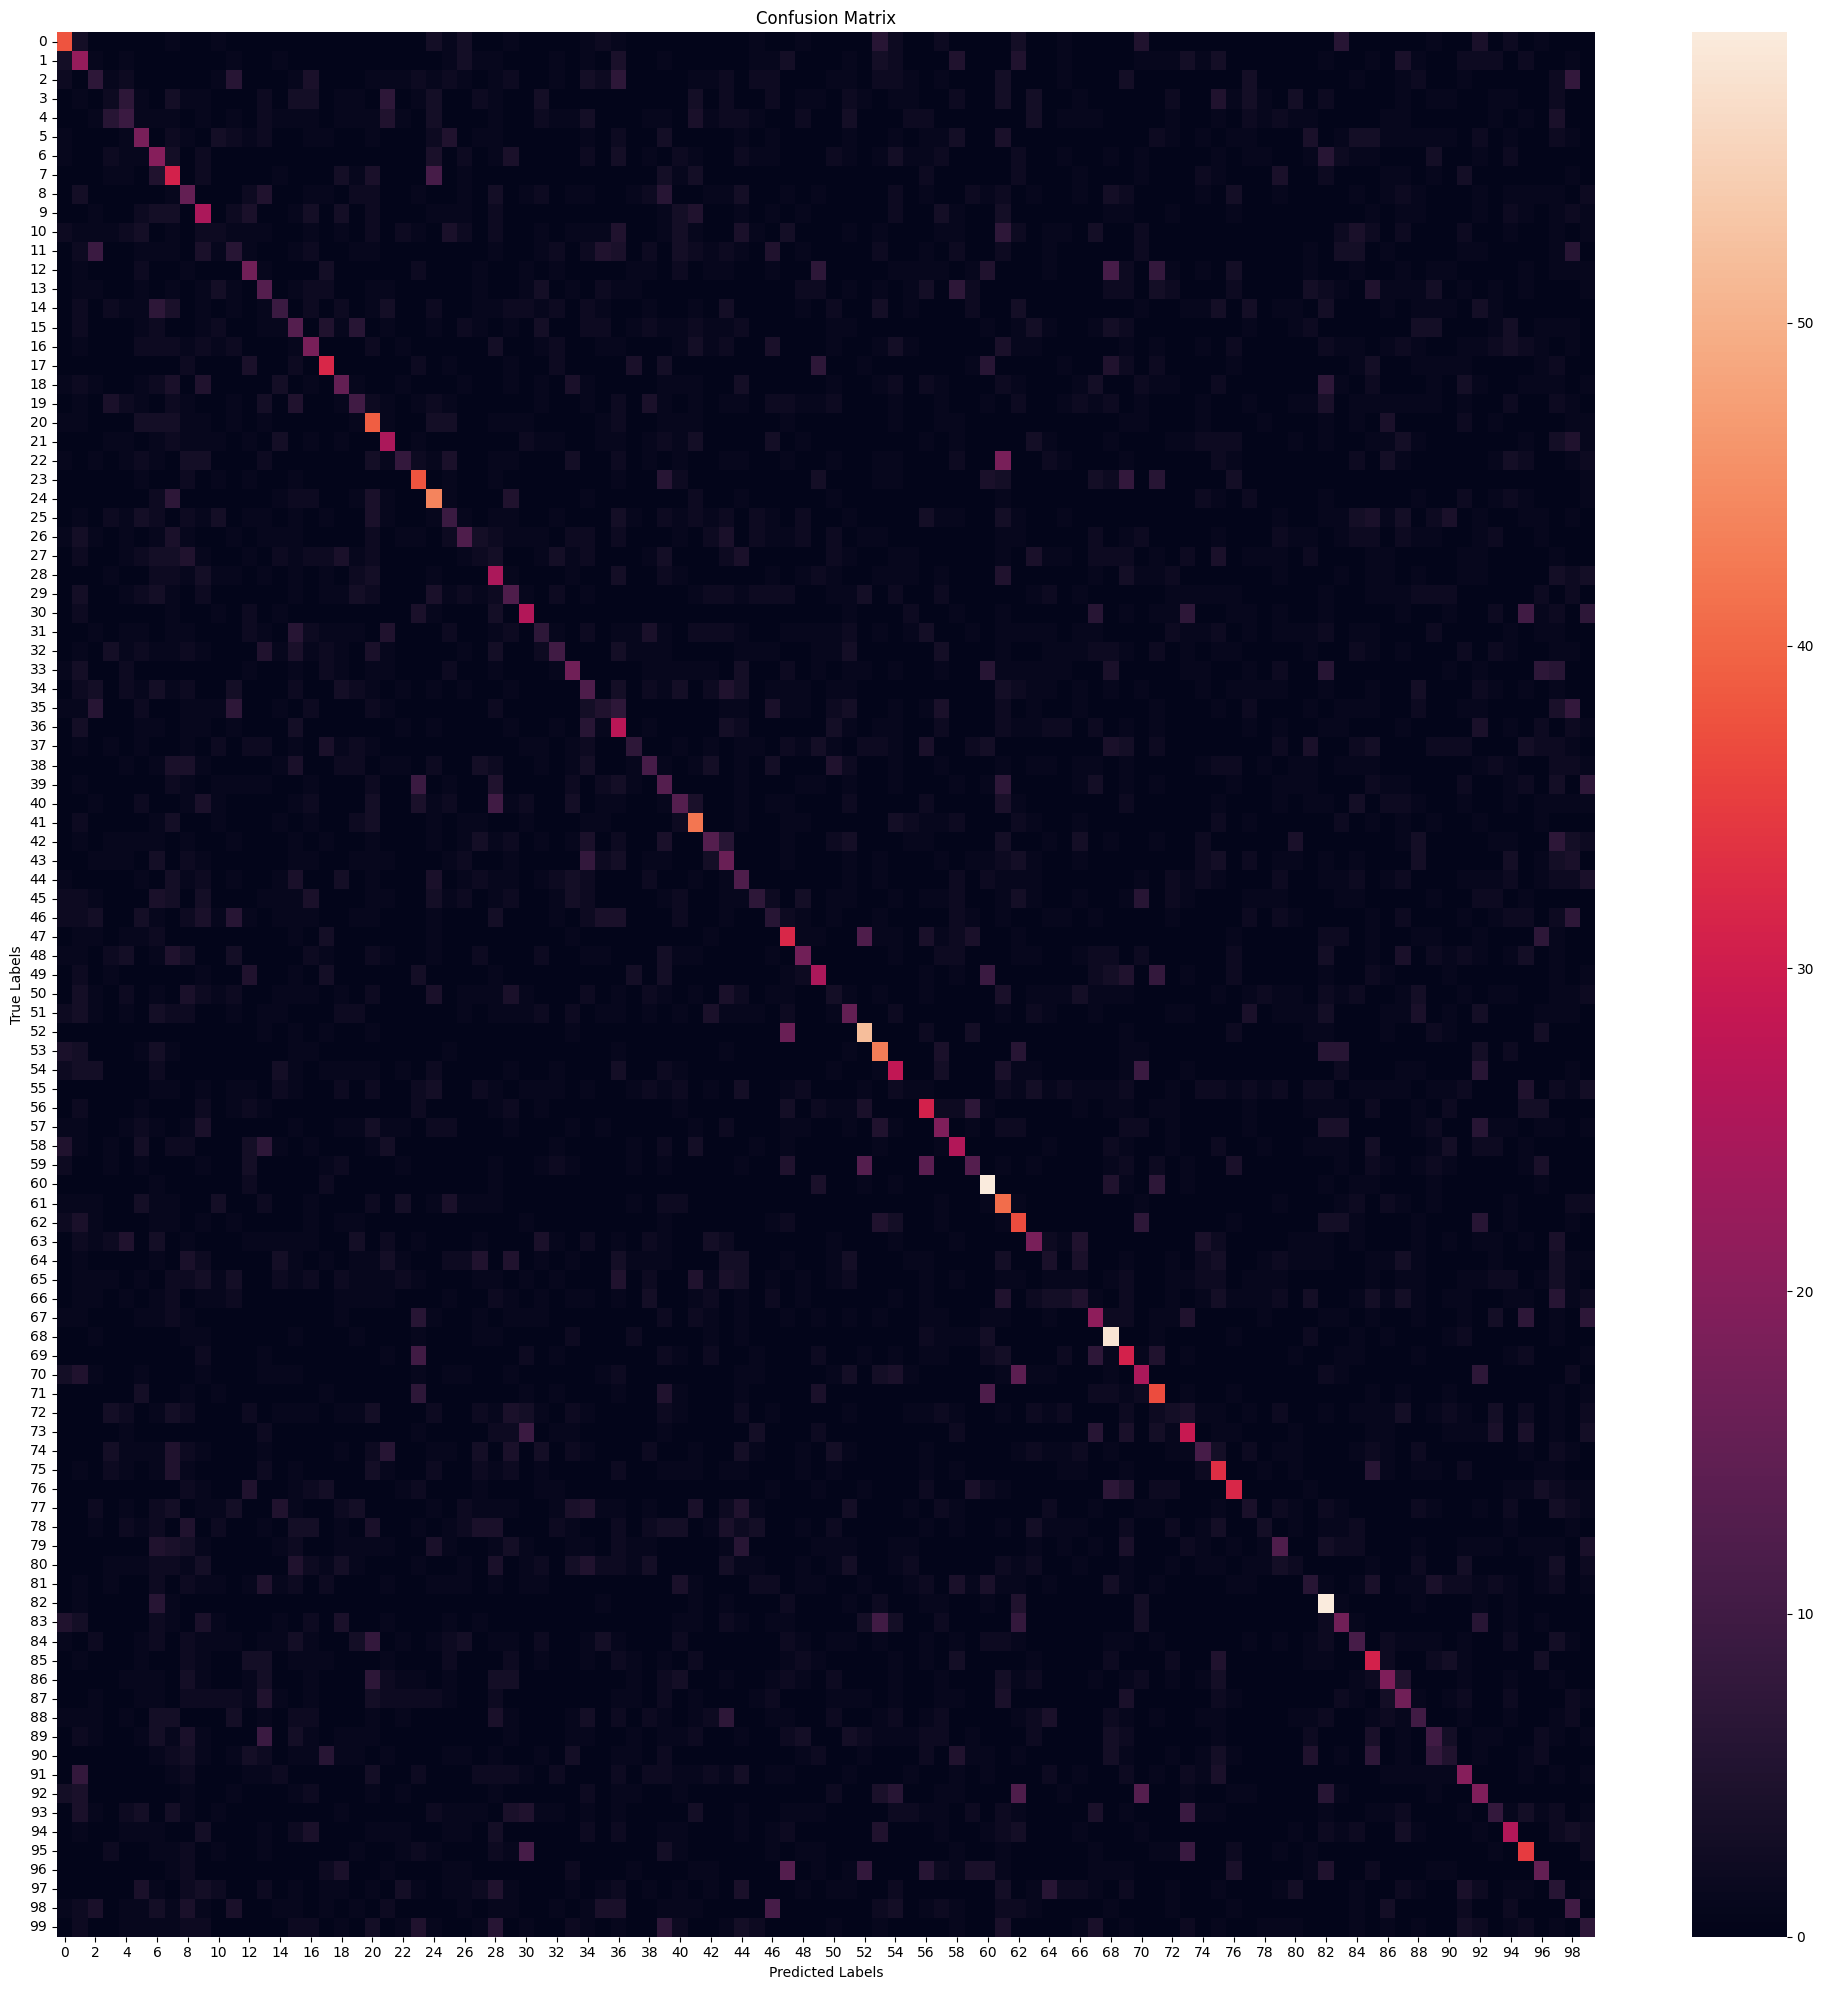

                   precision    recall  f1-score   support

           beaver       0.41      0.42      0.42        90
          dolphin       0.16      0.24      0.19        90
            otter       0.11      0.08      0.09        90
             seal       0.04      0.02      0.03        90
            whale       0.12      0.10      0.11        90
    aquarium fish       0.18      0.20      0.19        90
         flatfish       0.14      0.22      0.17        90
              ray       0.20      0.34      0.25        90
            shark       0.12      0.17      0.14        90
            trout       0.20      0.28      0.23        90
          orchids       0.04      0.02      0.03        90
          poppies       0.08      0.07      0.07        90
            roses       0.22      0.19      0.20        90
       sunflowers       0.13      0.14      0.14        90
           tulips       0.15      0.10      0.12        90
          bottles       0.12      0.14      0.13       

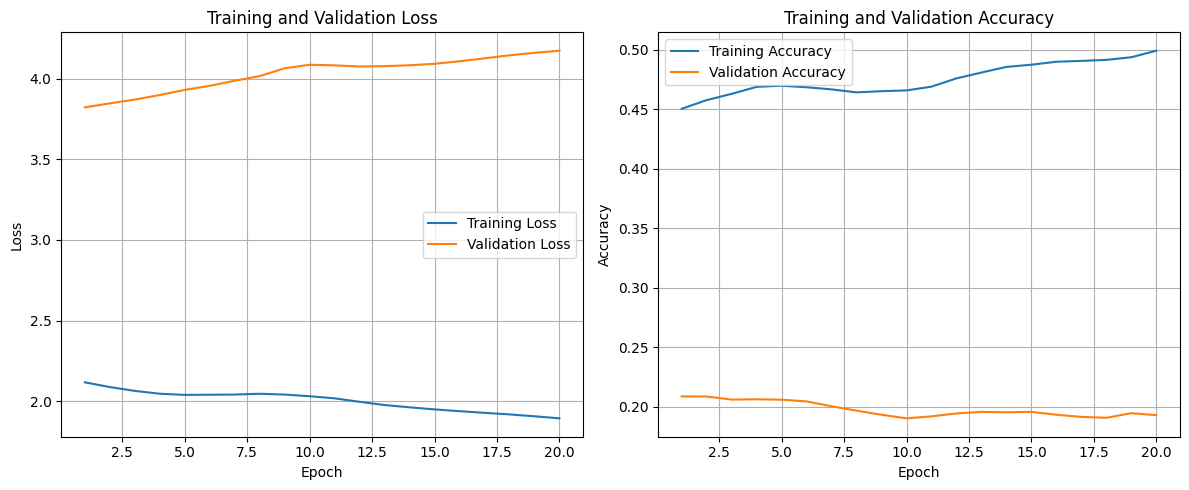

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2036 - loss: 4.1234
Test Accuracy: 19.69%
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


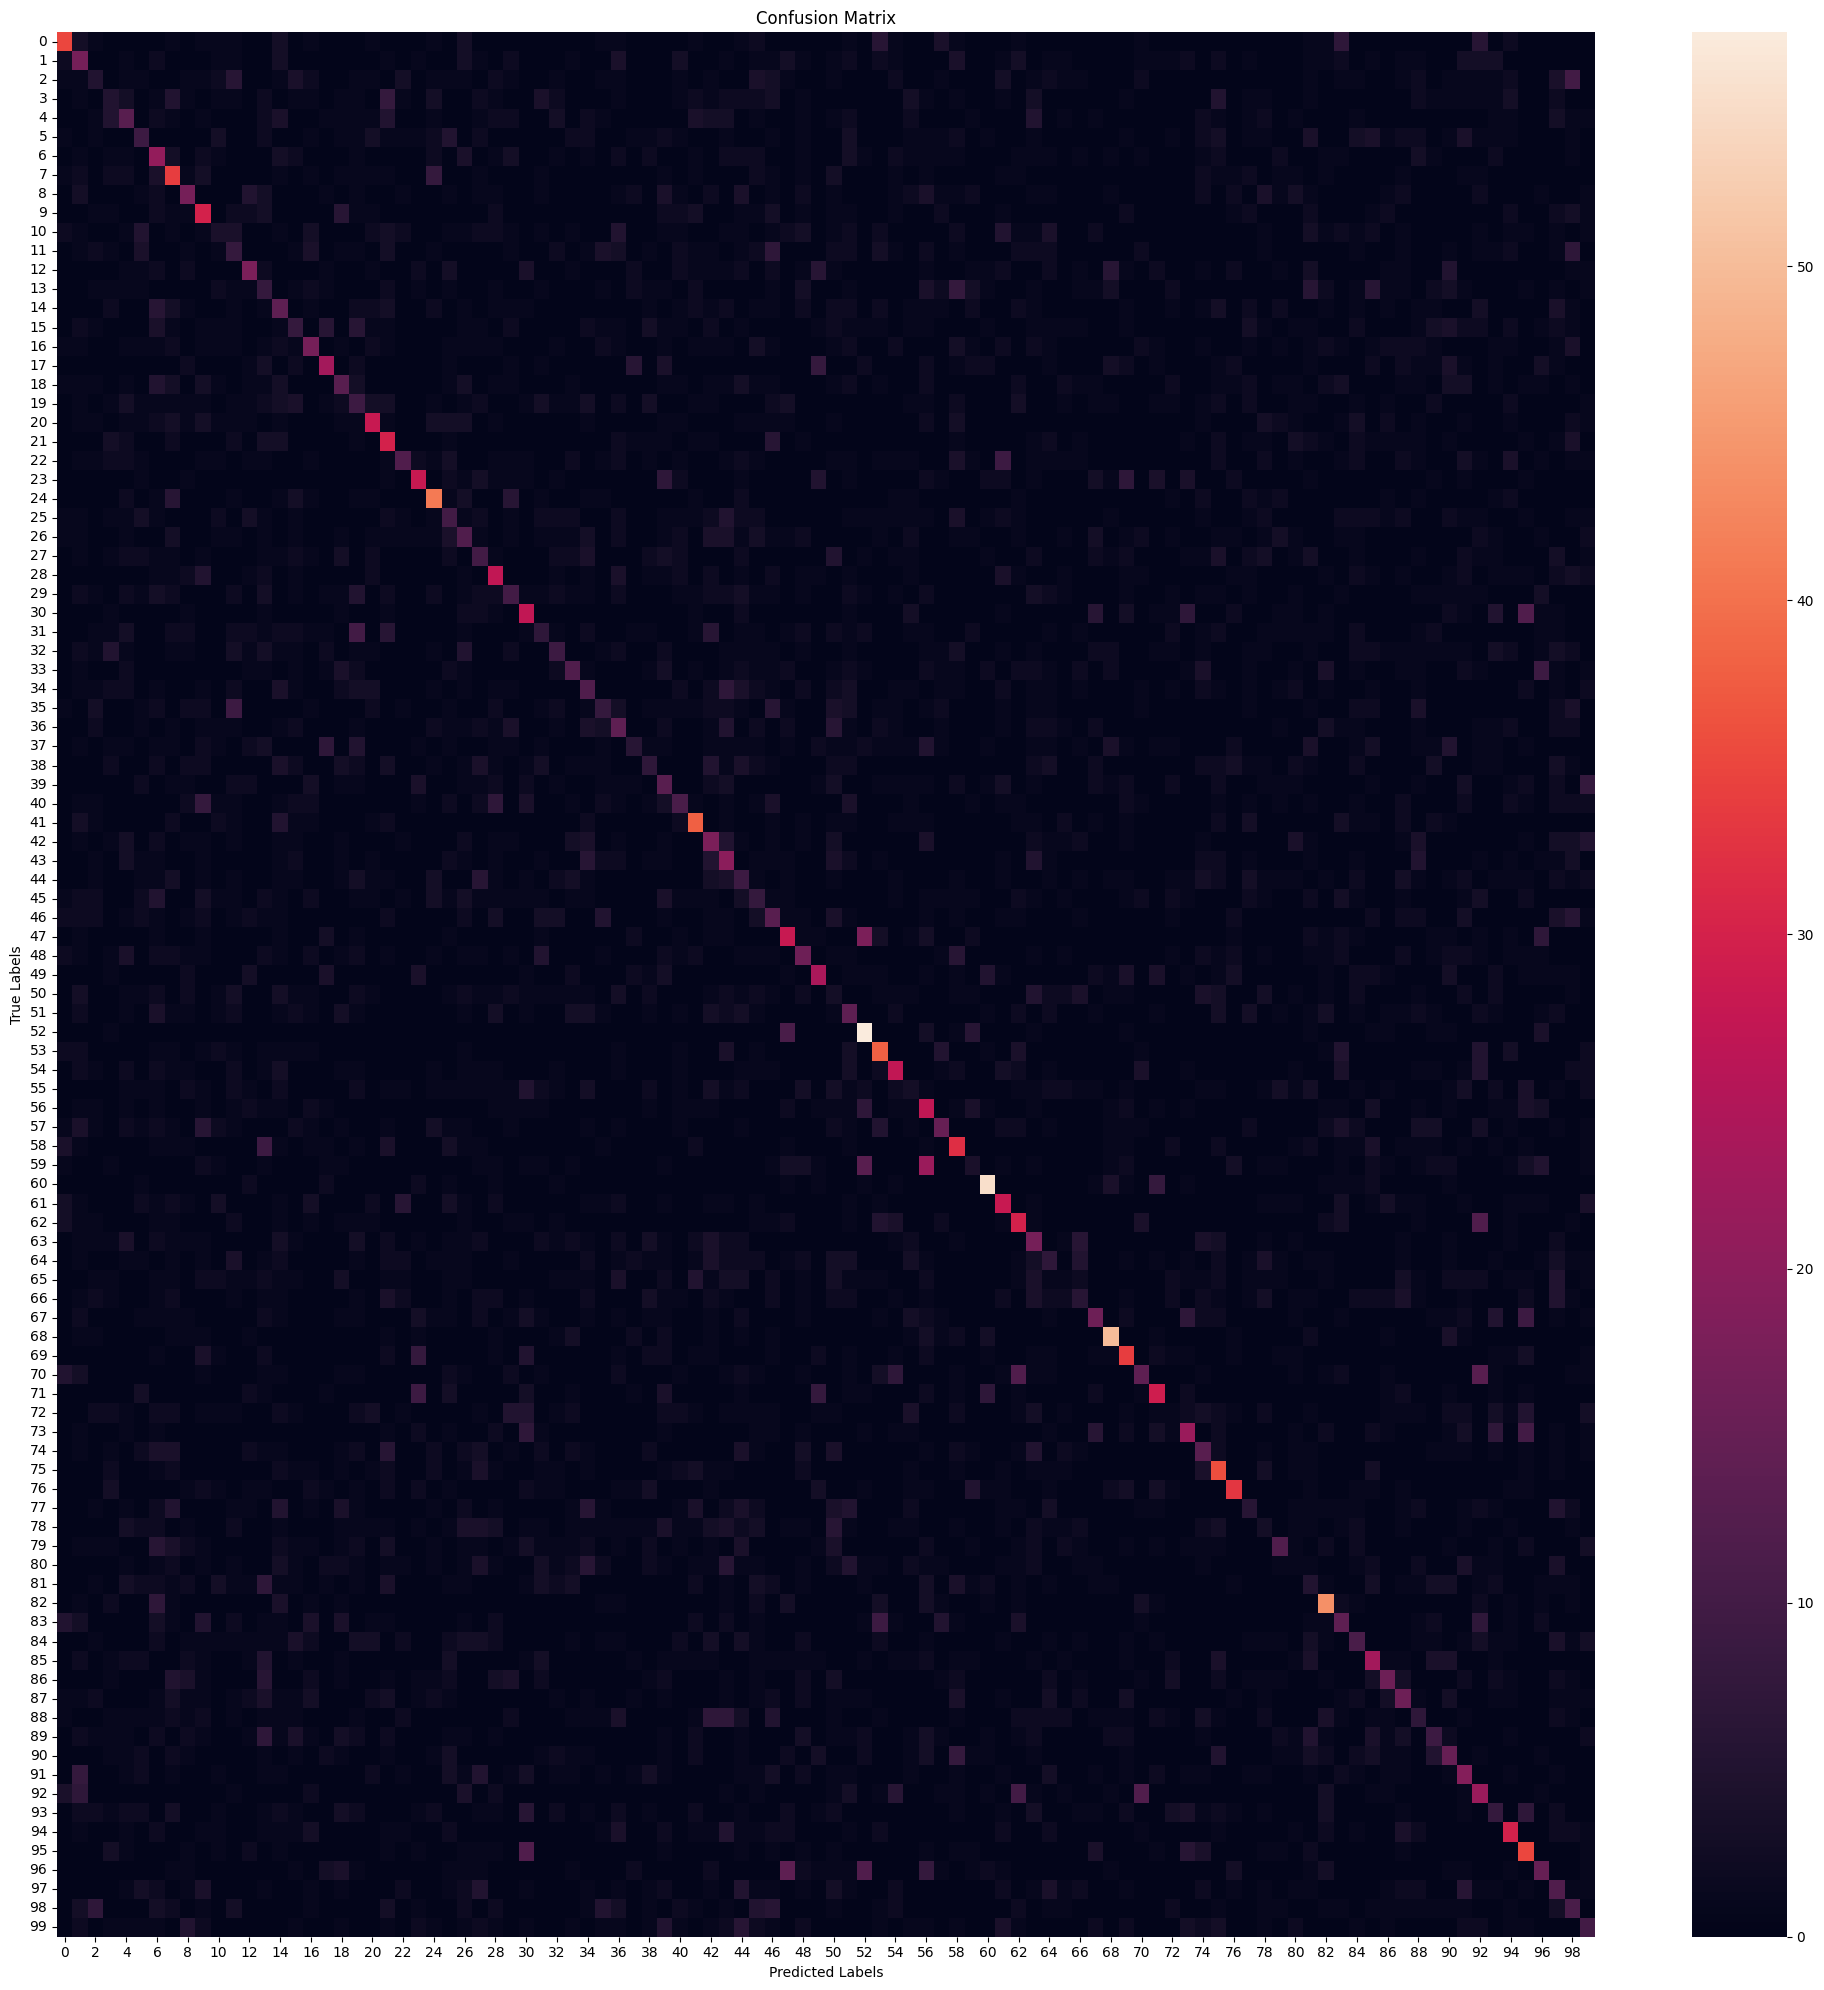

                   precision    recall  f1-score   support

           beaver       0.43      0.39      0.41        90
          dolphin       0.14      0.19      0.16        90
            otter       0.08      0.06      0.07        90
             seal       0.07      0.06      0.06        90
            whale       0.13      0.14      0.14        90
    aquarium fish       0.12      0.10      0.11        90
         flatfish       0.14      0.23      0.18        90
              ray       0.24      0.38      0.29        90
            shark       0.20      0.19      0.19        90
            trout       0.24      0.33      0.28        90
          orchids       0.08      0.04      0.06        90
          poppies       0.08      0.09      0.09        90
            roses       0.26      0.20      0.23        90
       sunflowers       0.07      0.09      0.08        90
           tulips       0.11      0.16      0.13        90
          bottles       0.10      0.09      0.10       

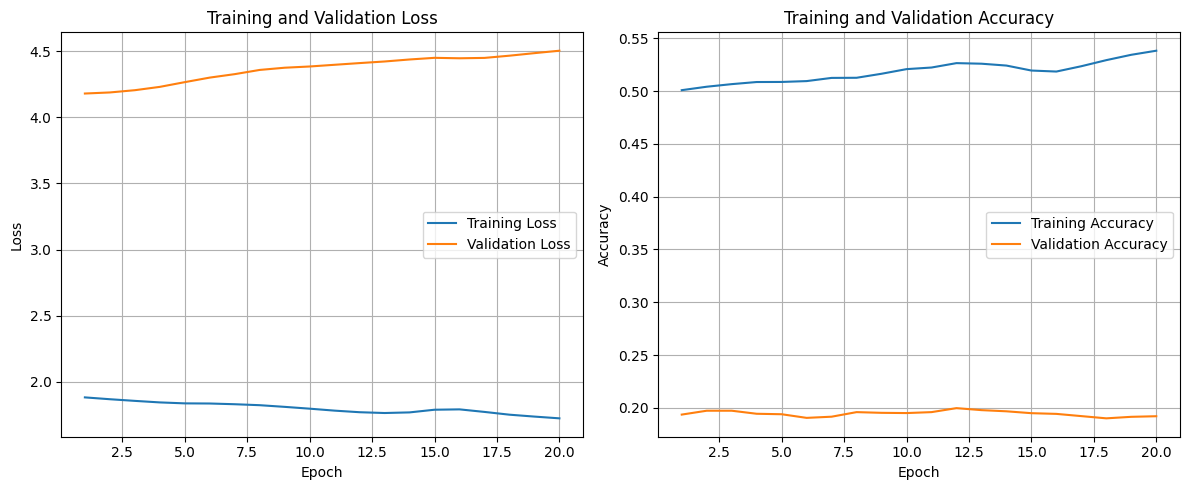

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1896 - loss: 4.5084
Test Accuracy: 19.00%
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


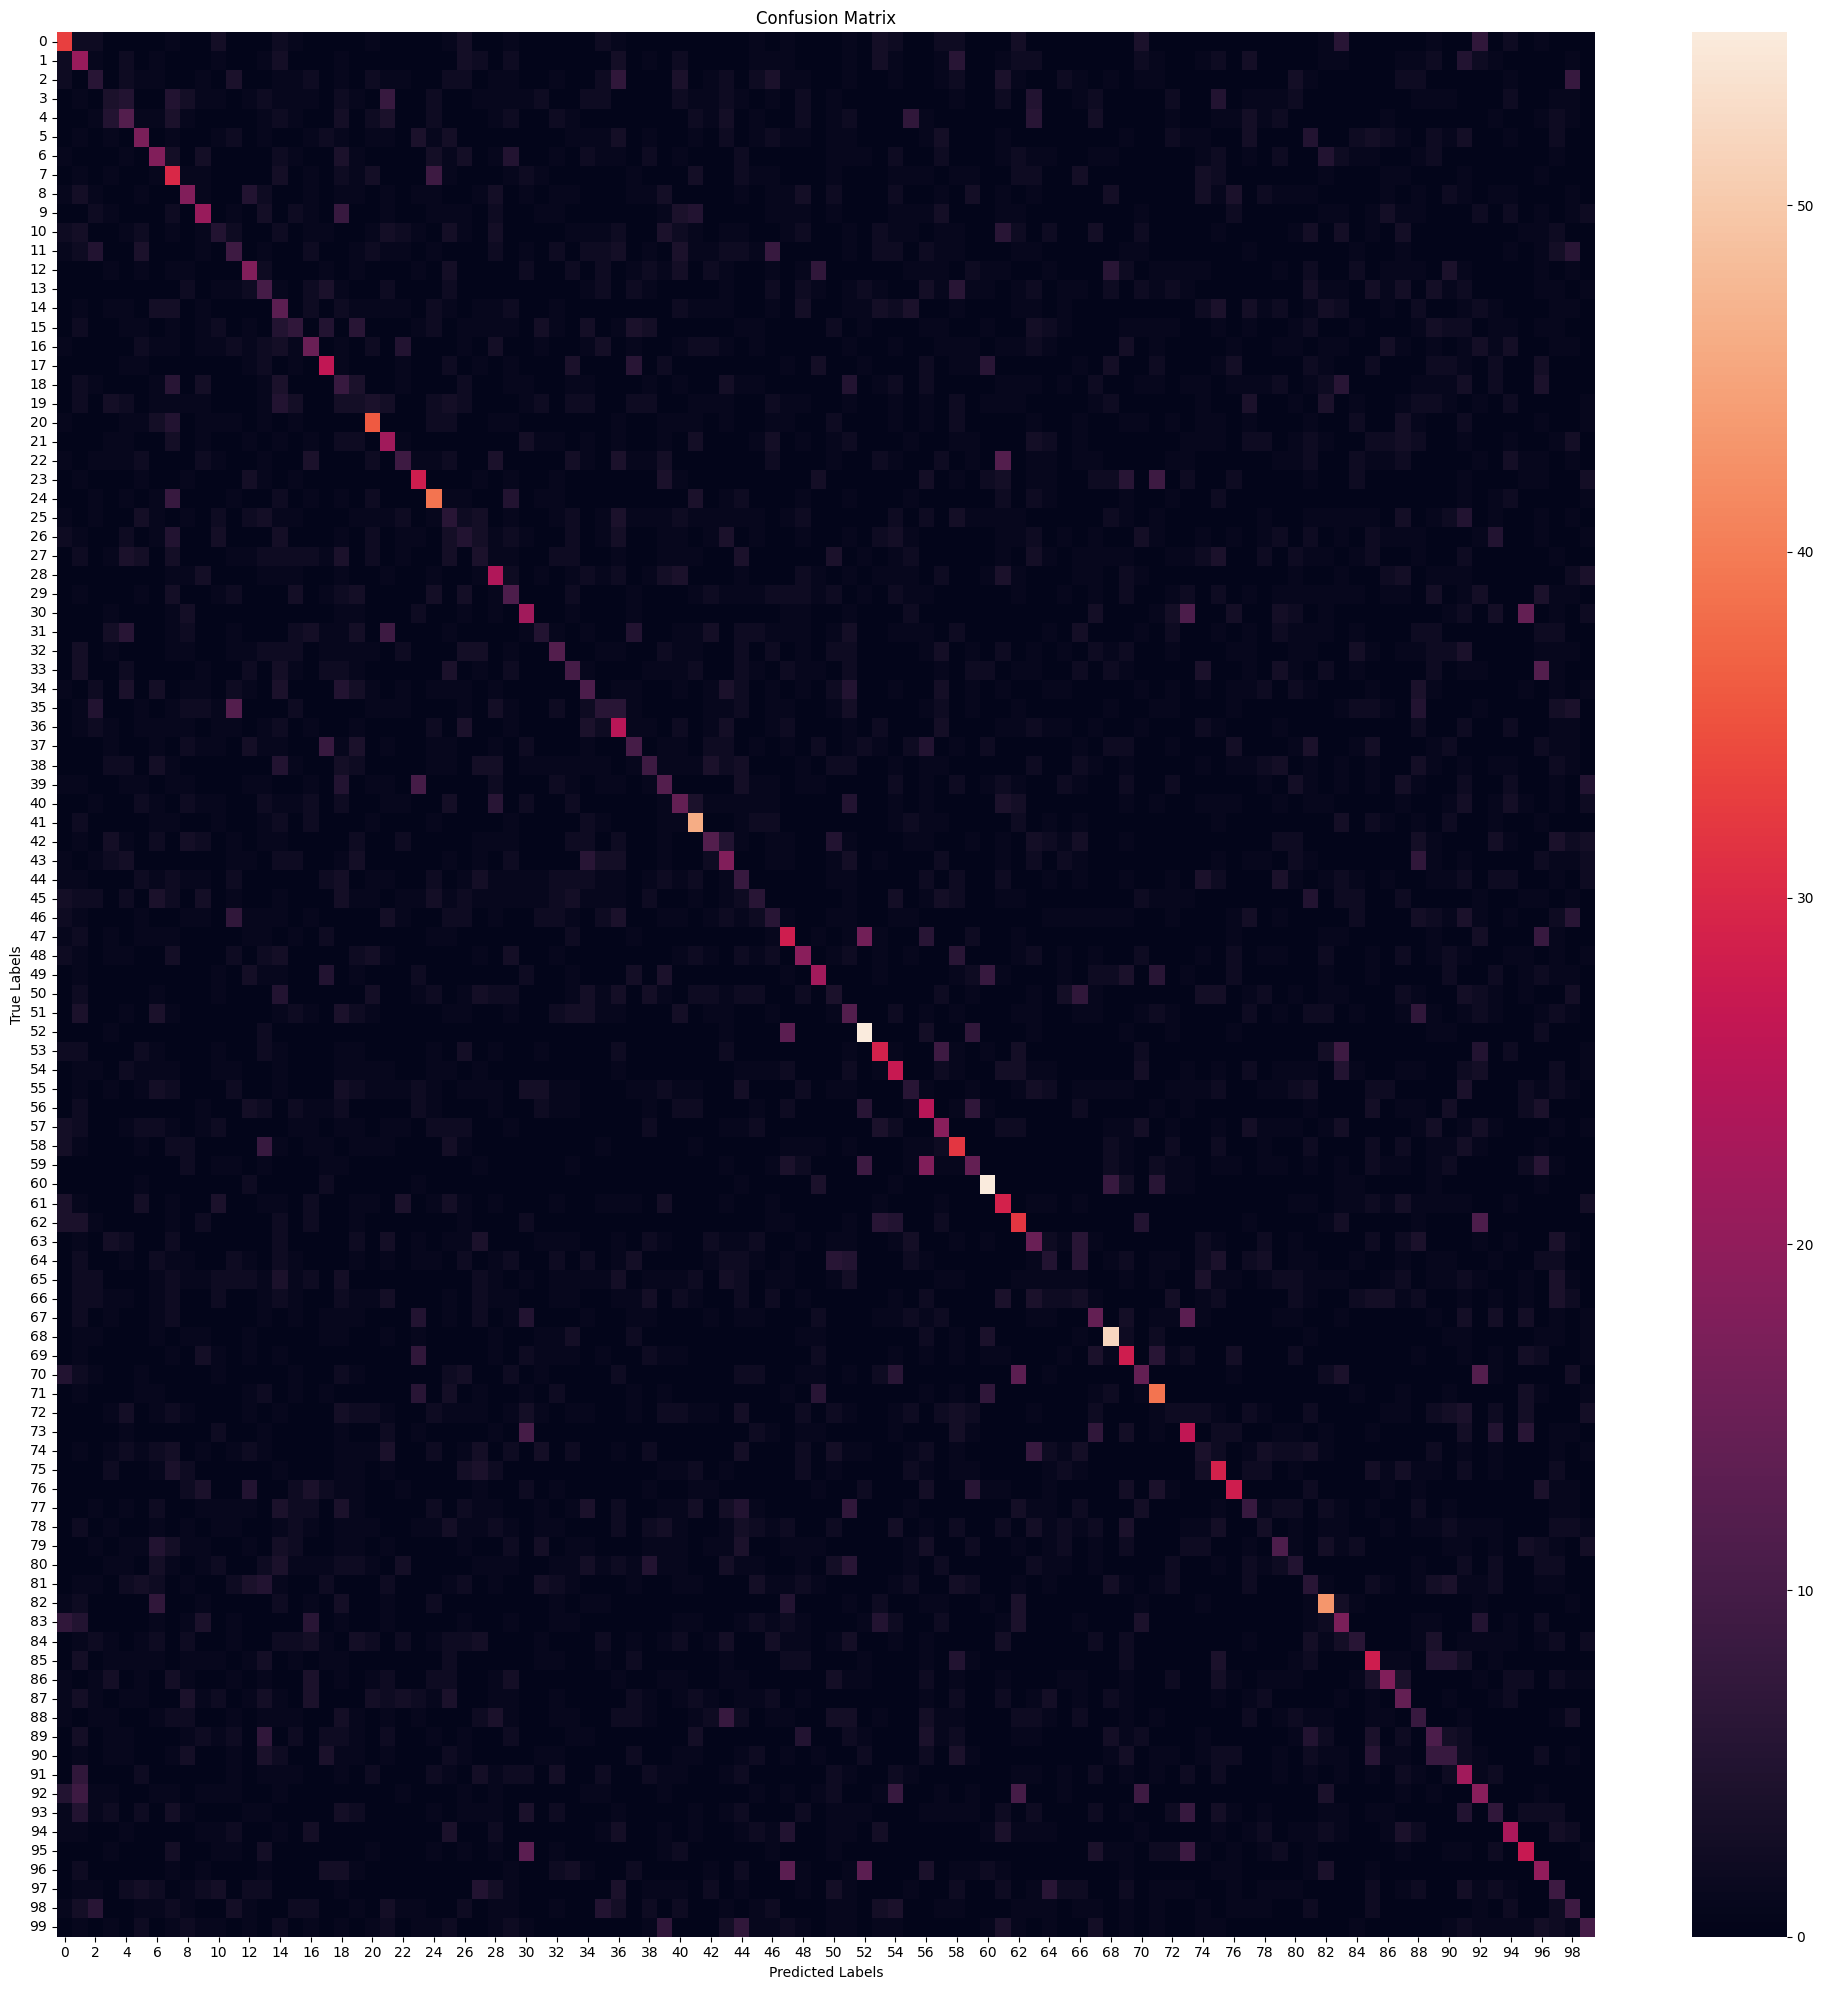

                   precision    recall  f1-score   support

           beaver       0.33      0.37      0.35        90
          dolphin       0.14      0.23      0.17        90
            otter       0.10      0.07      0.08        90
             seal       0.06      0.04      0.05        90
            whale       0.14      0.13      0.14        90
    aquarium fish       0.20      0.19      0.20        90
         flatfish       0.17      0.20      0.19        90
              ray       0.20      0.33      0.25        90
            shark       0.21      0.20      0.21        90
            trout       0.24      0.23      0.23        90
          orchids       0.08      0.06      0.07        90
          poppies       0.11      0.10      0.10        90
            roses       0.22      0.20      0.21        90
       sunflowers       0.09      0.11      0.10        90
           tulips       0.09      0.14      0.11        90
          bottles       0.10      0.08      0.09       

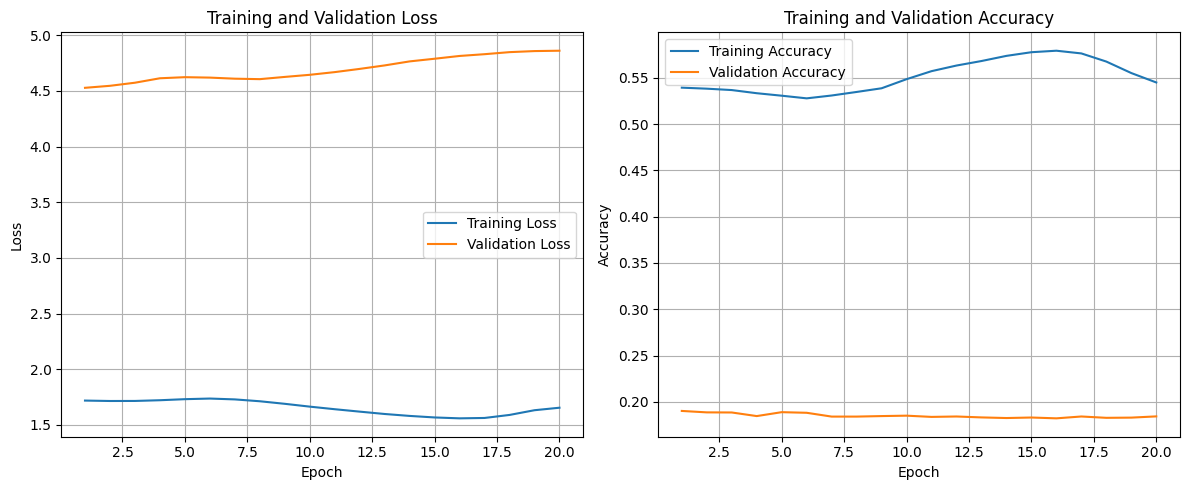

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1810 - loss: 4.8245
Test Accuracy: 18.23%
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


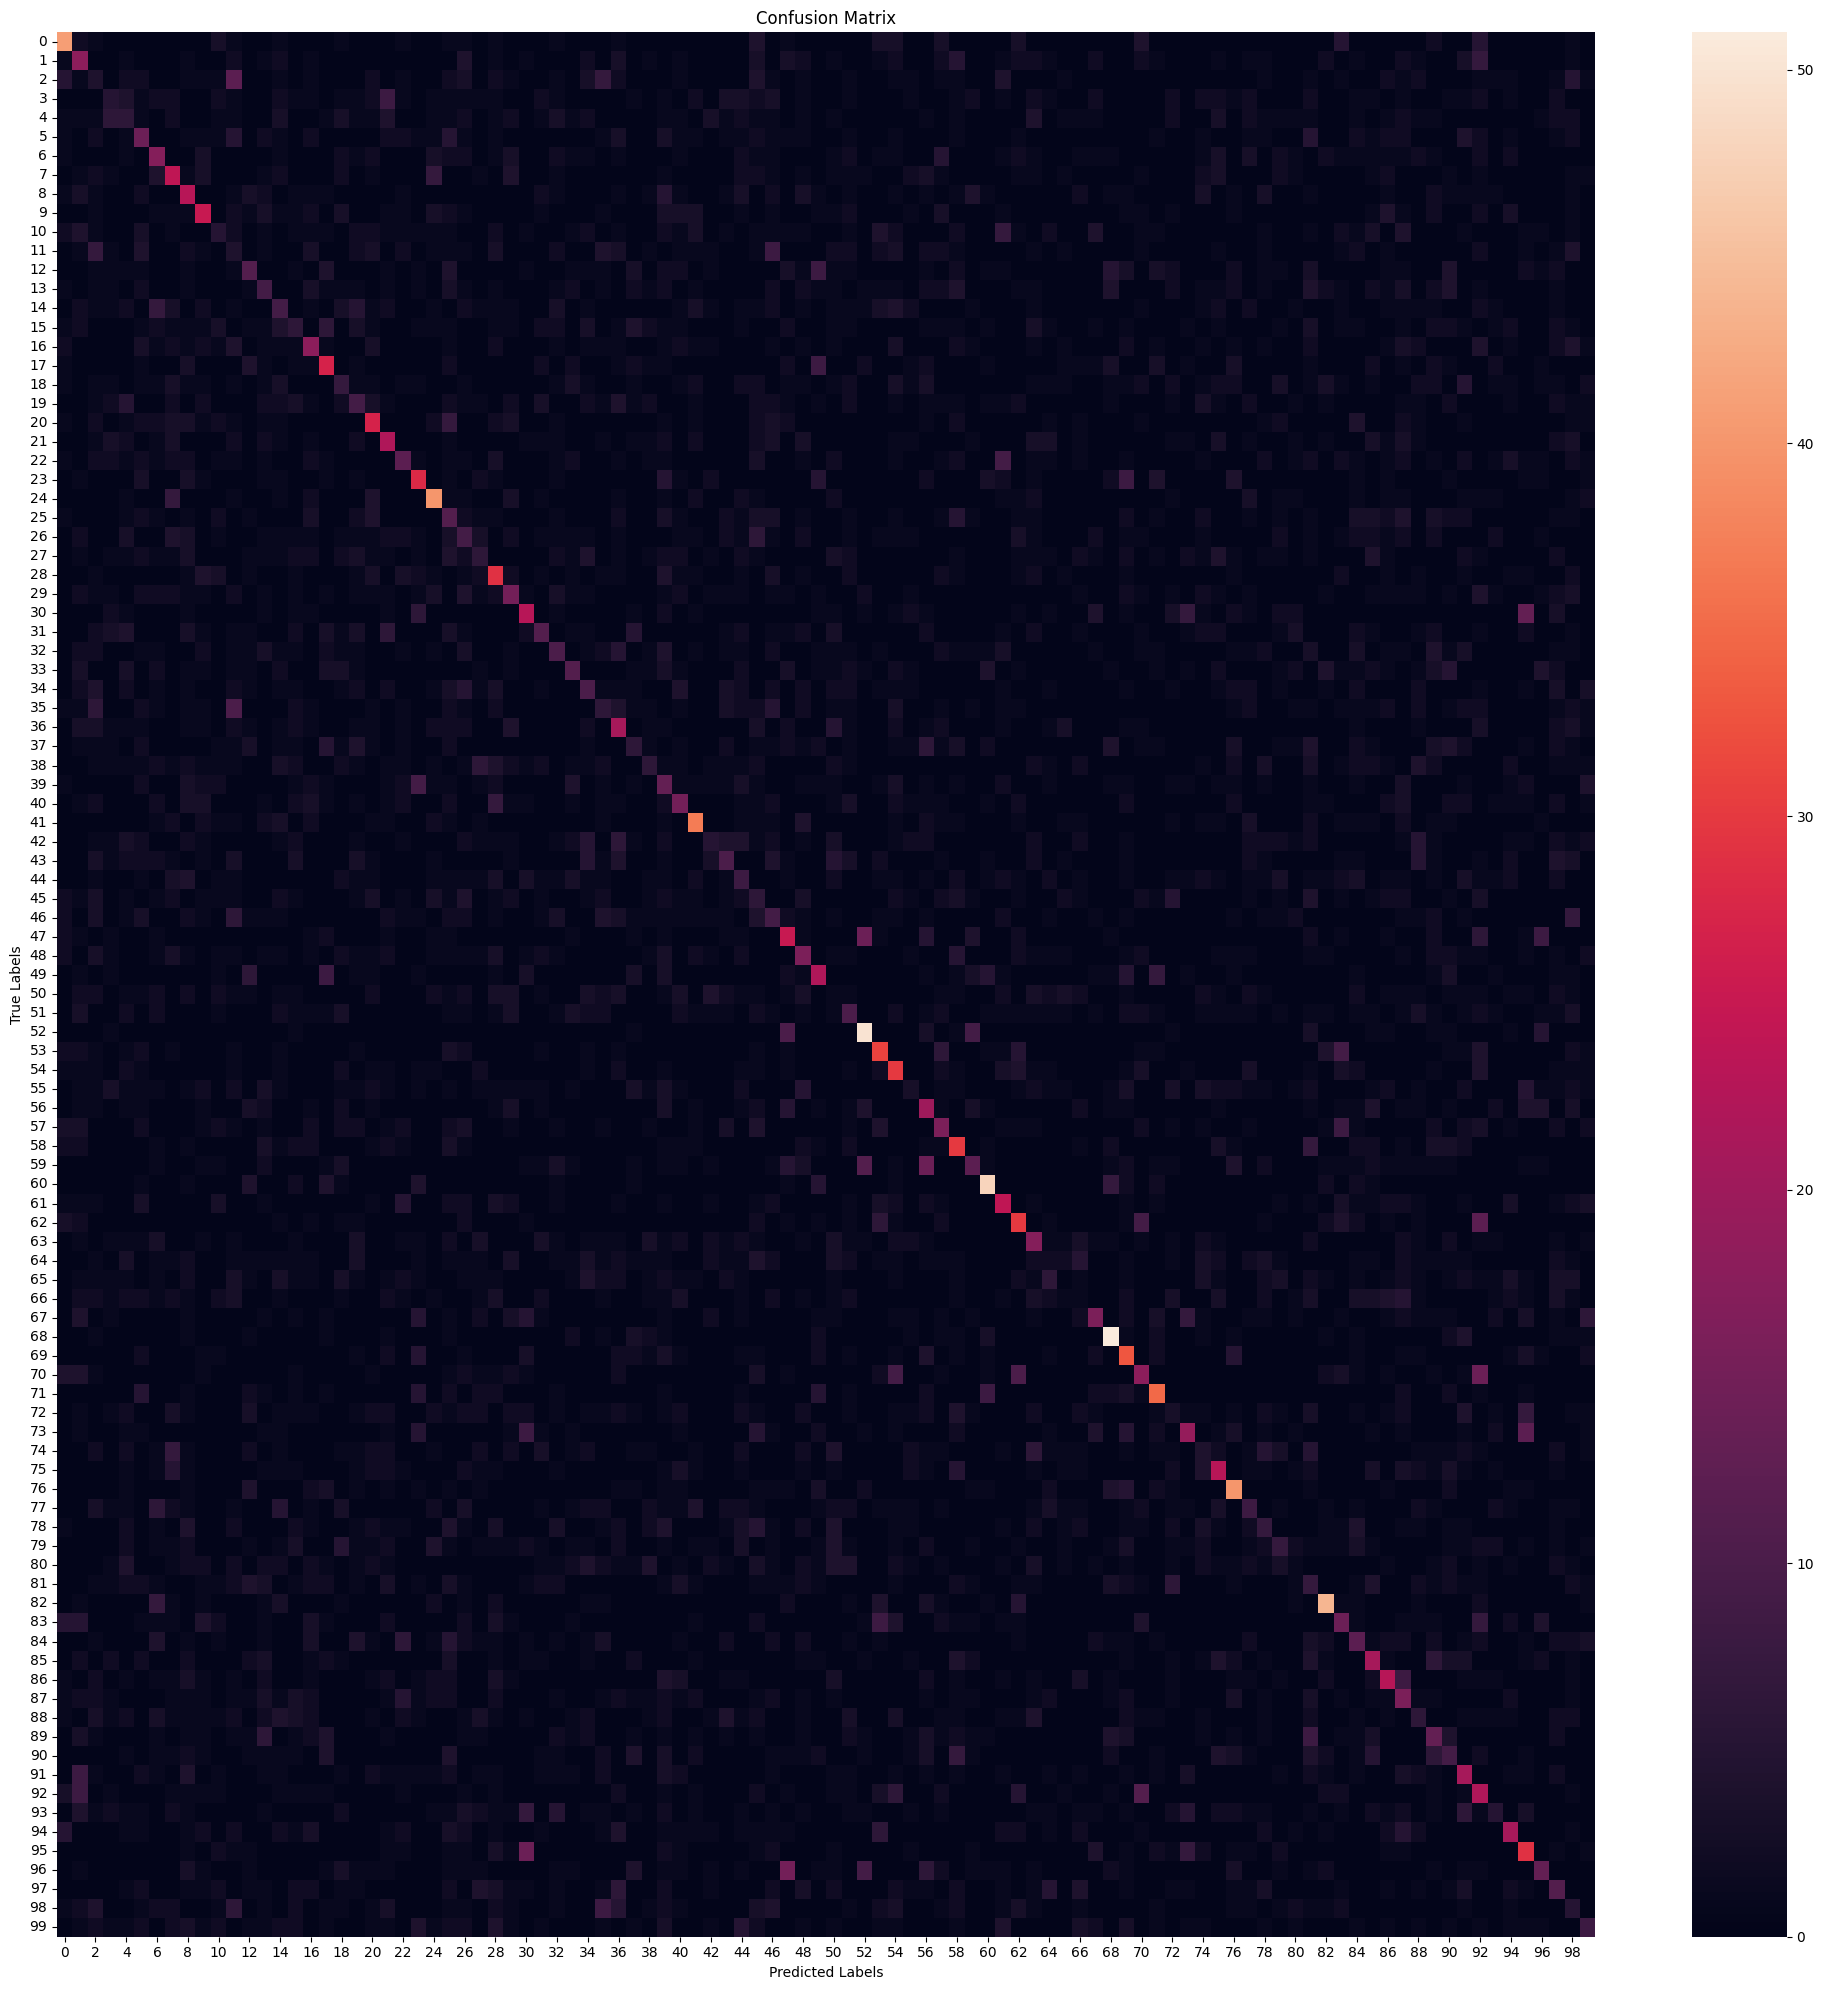

                   precision    recall  f1-score   support

           beaver       0.39      0.46      0.42        90
          dolphin       0.14      0.20      0.17        90
            otter       0.04      0.04      0.04        90
             seal       0.08      0.06      0.07        90
            whale       0.06      0.07      0.07        90
    aquarium fish       0.14      0.16      0.15        90
         flatfish       0.17      0.19      0.18        90
              ray       0.22      0.27      0.24        90
            shark       0.17      0.26      0.21        90
            trout       0.27      0.28      0.27        90
          orchids       0.08      0.06      0.07        90
          poppies       0.04      0.04      0.04        90
            roses       0.15      0.12      0.13        90
       sunflowers       0.10      0.10      0.10        90
           tulips       0.09      0.10      0.10        90
          bottles       0.08      0.07      0.07       

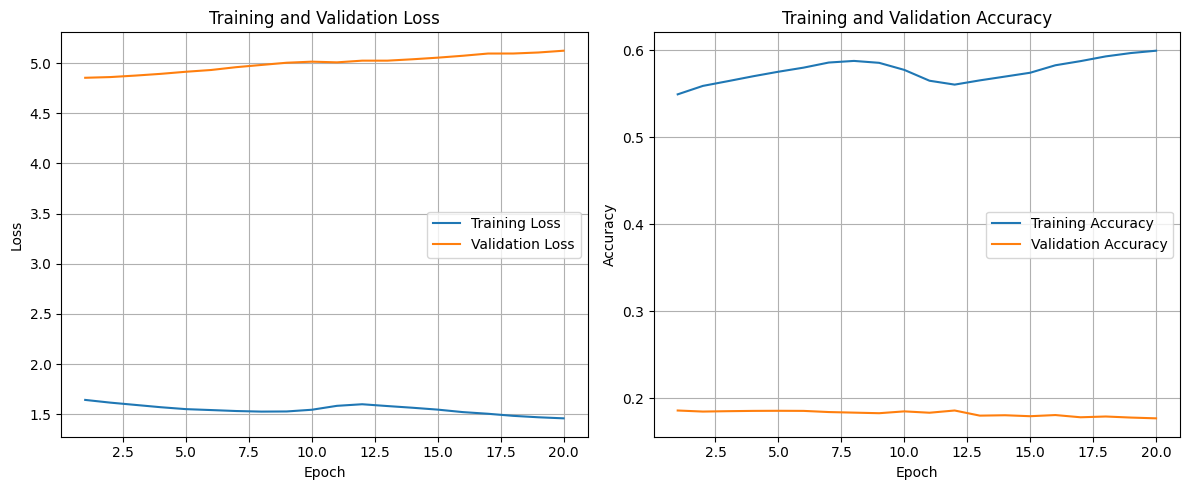

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1769 - loss: 5.0844
Test Accuracy: 17.59%
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


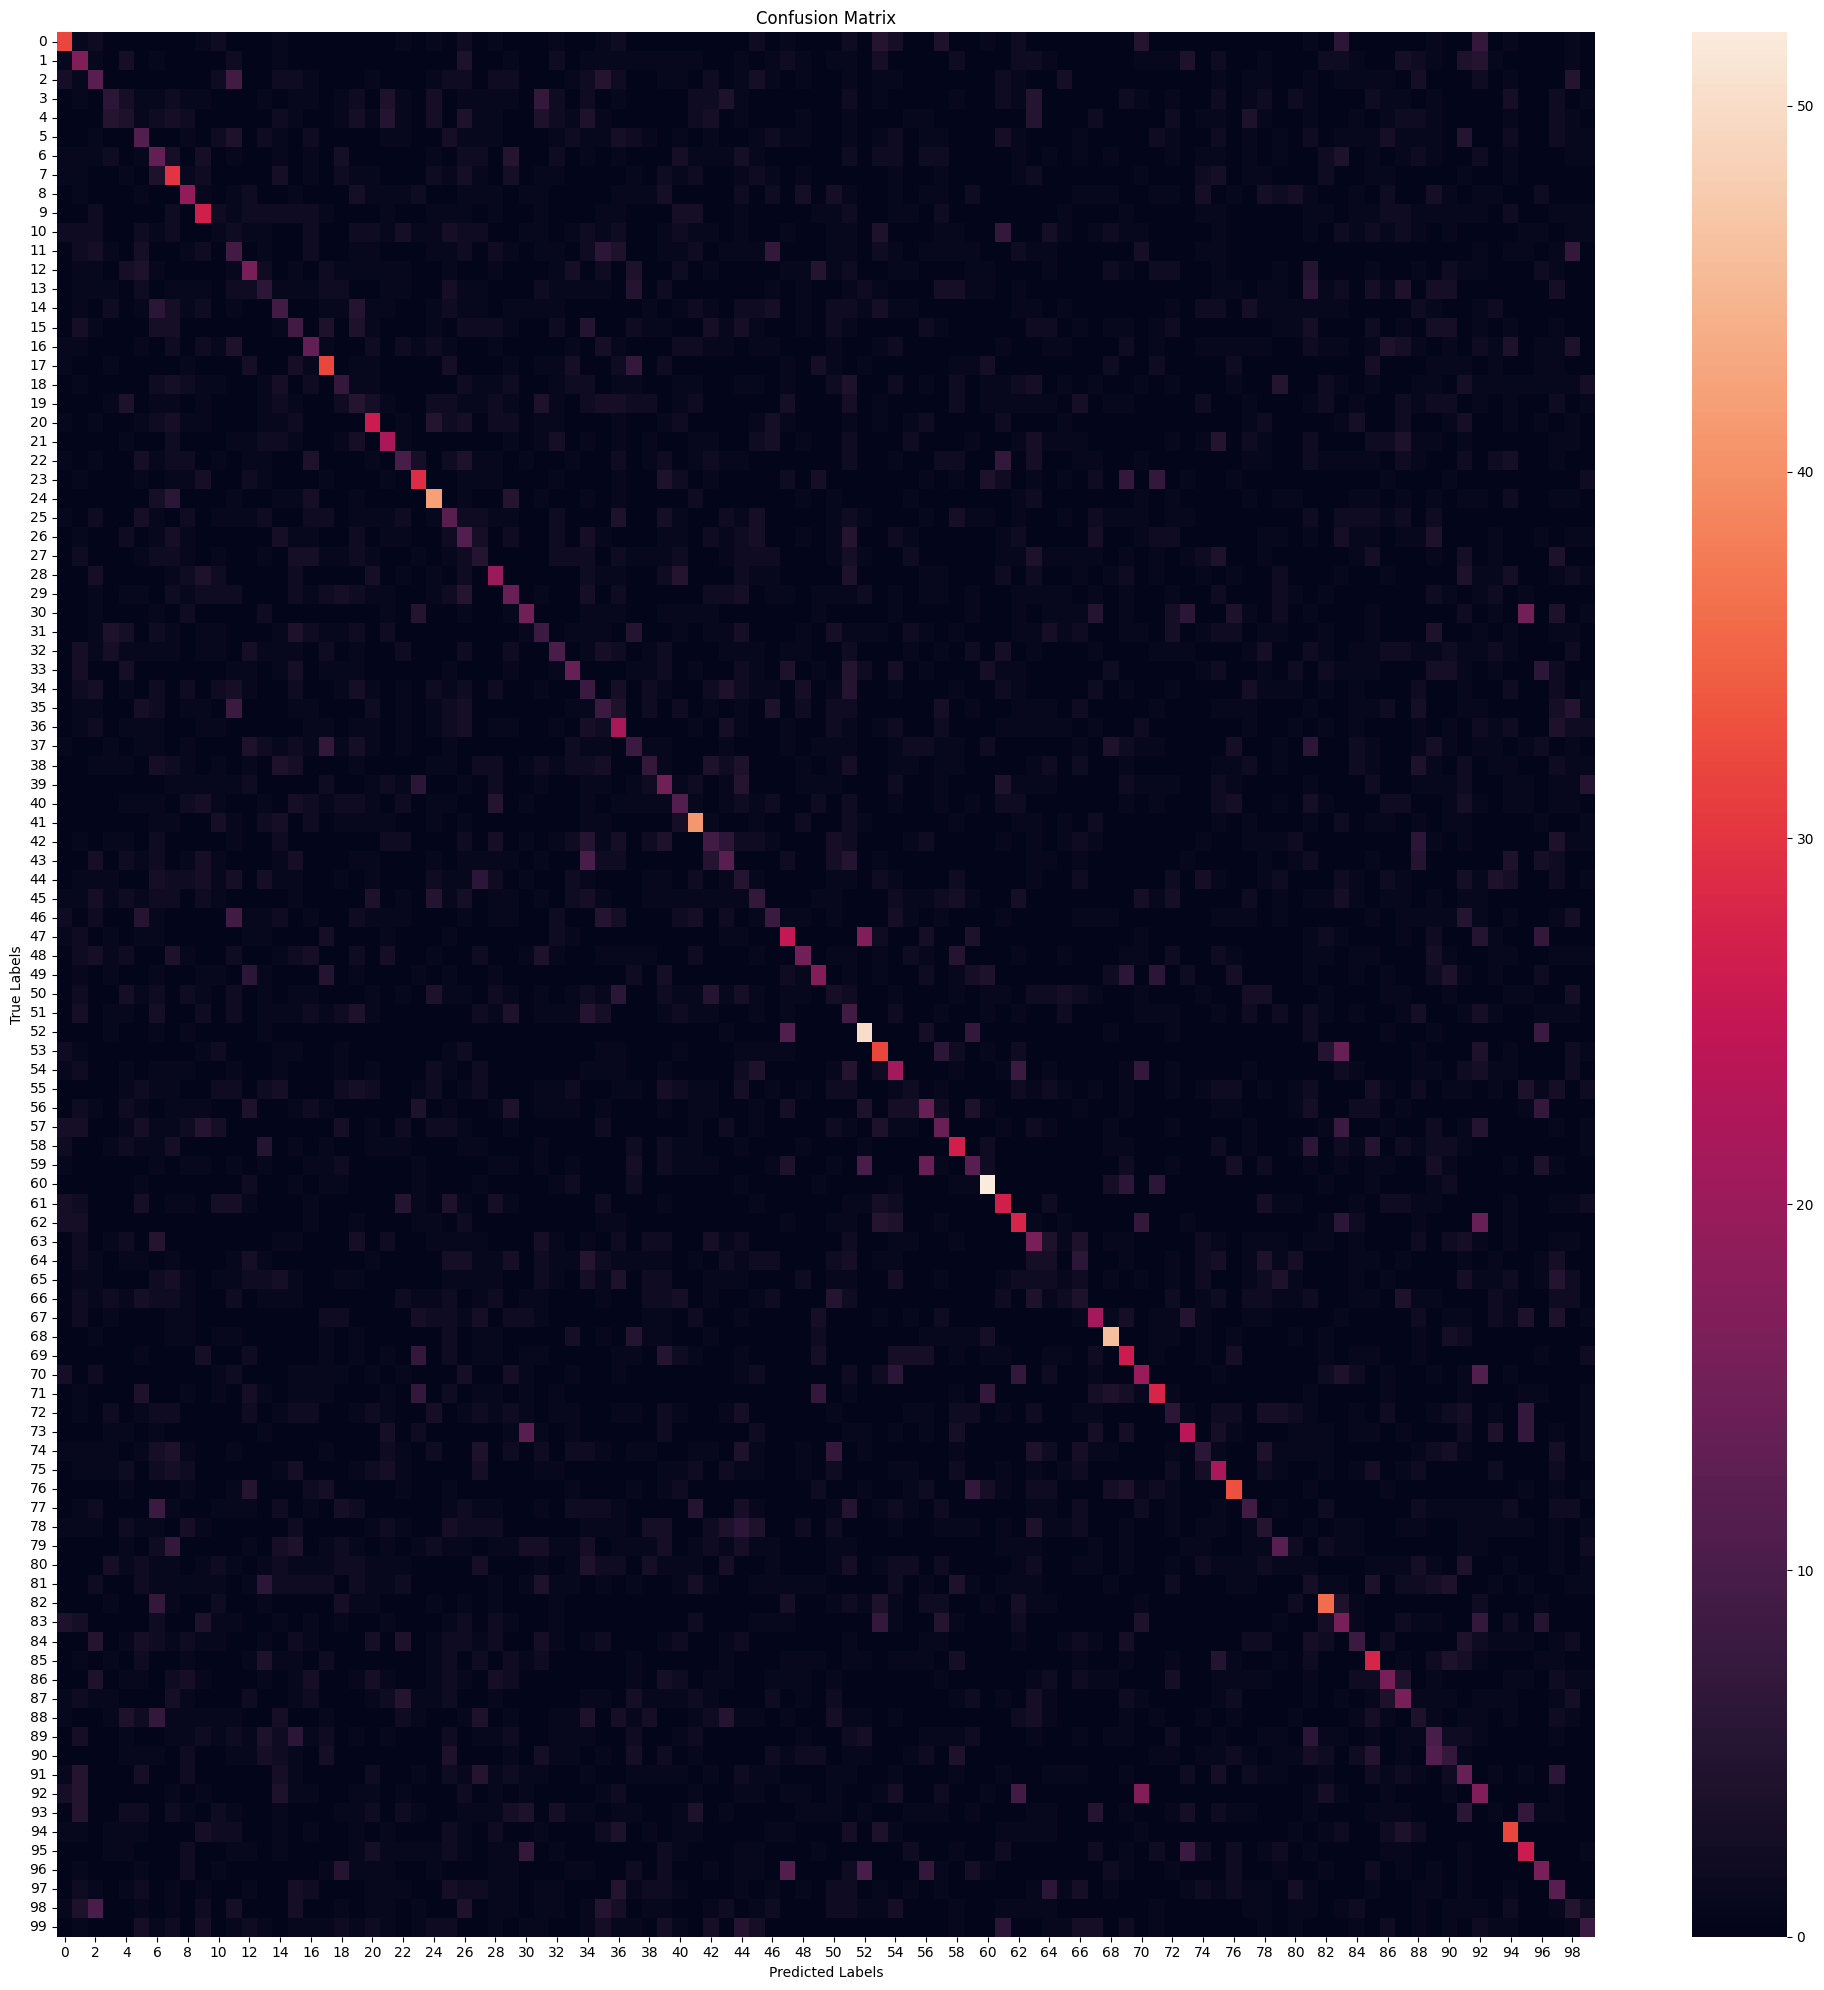

                   precision    recall  f1-score   support

           beaver       0.39      0.36      0.37        90
          dolphin       0.14      0.19      0.16        90
            otter       0.13      0.13      0.13        90
             seal       0.11      0.07      0.08        90
            whale       0.05      0.04      0.05        90
    aquarium fish       0.11      0.12      0.11        90
         flatfish       0.10      0.14      0.12        90
              ray       0.21      0.33      0.26        90
            shark       0.20      0.21      0.21        90
            trout       0.25      0.30      0.27        90
          orchids       0.02      0.01      0.01        90
          poppies       0.08      0.10      0.09        90
            roses       0.18      0.18      0.18        90
       sunflowers       0.08      0.07      0.07        90
           tulips       0.09      0.10      0.10        90
          bottles       0.08      0.10      0.09       

In [16]:
for xxxx in range(5):
    # reduceLR = ReduceLROnPateau(monitor='val_accuracy', factor=0.1, patience=3, min_delta=0.01, mode="auto")

    # Train model
    history = model.fit(train_dataset, validation_data=val_dataset, epochs=20, verbose=1)

    # Extract loss and accuracy
    epochs = range(1,len(history.history['loss'])+1)
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    plot_evidence(epochs, train_loss, val_loss, train_acc, val_acc)

    # Evaluate on test data
    test_loss, test_acc = model.evaluate(test_dataset)
    print(f"Test Accuracy: {test_acc*100:.2f}%")

    # Get predictions
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = y_test.flatten()

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

    # Plot confusion matrix
    plt.figure(figsize=(20, 20))
    sns.heatmap(conf_matrix) #cmap='Blues', fmt='d'
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    print(classification_report(y_true_classes, y_pred_classes, target_names=labels_names))